In [133]:
# ======================================
# Common imports
# ======================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.pipeline import Pipeline

import os
import warnings
warnings.filterwarnings('ignore')

# ======================================
# Config – change to match your files/columns
# ======================================
DATE_COL = "Date"               # change if your date column has a different name
IG_TARGET = "dIG_spread"
HY_TARGET = "dHY_spread"

IG_WO_LQD_FILE = "master_IG_wo_lqd.csv"
HY_WO_LQD_FILE = "master_HY_wo_lqd.csv"
IG_W_LQD_FILE  = "master_IG_w_lqd.csv"
HY_W_LQD_FILE  = "master_HY_w_lqd.csv"

In [160]:
ig_wo = load_data(IG_WO_LQD_FILE)
hy_wo = load_data(HY_WO_LQD_FILE)

ig_w = load_data(IG_W_LQD_FILE)
hy_w = load_data(HY_W_LQD_FILE)

In [148]:
# ======================================
# Helper functions
# ======================================

def load_data(path, date_col=DATE_COL):
    """Load CSV and parse date column."""
    df = pd.read_csv(os.path.dirname(os.getcwd())+"/data/master/" + path)
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.sort_values(date_col)
    return df

def make_X_y(df, target, date_col=DATE_COL):
    """
    Build (X, y) from a cleaned dataframe:
    - drops rows with NaNs in predictors/target
    - uses only numeric predictors, excluding date and target.
    """
    # Keep only numeric columns
    num_df = df.select_dtypes(include=[np.number]).copy()
    # Drop target from X; y is target
    y = num_df[target]
    X = num_df.drop(columns=[target])
    # Drop rows with missing values in either X or y
    data = pd.concat([X, y], axis=1).dropna()
    y = data[target]
    X = data.drop(columns=[target])
    # Add constant for statsmodels
    X = sm.add_constant(X)
    return X, y

def compute_vif(X):
    """
    Compute VIF for each predictor (excluding the constant).
    """
    X_no_const = X.drop(columns=["const"], errors="ignore")
    vif_data = []
    for i, col in enumerate(X_no_const.columns):
        vif = variance_inflation_factor(X_no_const.values, i)
        vif_data.append((col, vif))
    vif_df = pd.DataFrame(vif_data, columns=["variable", "VIF"])
    return vif_df.sort_values("VIF", ascending=False)

def forward_stepwise_aic(X, y, max_features=5):
    """
    Simple forward stepwise selection using AIC.
    - Starts from const only, adds variables one by one.
    - Stops when no AIC improvement.
    """
    remaining = list(X.columns)
    if "const" in remaining:
        remaining.remove("const")
    selected = ["const"]
    current_aic = sm.OLS(y, X[selected]).fit().aic

    if max_features is None:
        max_features = len(remaining)

    while remaining and len(selected) - 1 < max_features:
        aic_with_candidates = []
        for candidate in remaining:
            cols = selected + [candidate]
            model = sm.OLS(y, X[cols]).fit()
            aic_with_candidates.append((model.aic, candidate))
        best_aic, best_candidate = min(aic_with_candidates, key=lambda t: t[0])

        if best_aic < current_aic:
            current_aic = best_aic
            selected.append(best_candidate)
            remaining.remove(best_candidate)
        else:
            break

    return selected  # includes 'const'

def influence_diagnostics(model, X, y, label=""):
    """
    Compute standardised residuals, leverage and Cook's distance.
    Flags potentially influential points.
    """
    infl = model.get_influence()
    n, p = X.shape

    df_infl = pd.DataFrame({
        "stud_resid": infl.resid_studentized_external,
        "leverage": infl.hat_matrix_diag,
        "cooks_d": infl.cooks_distance[0],
    }, index=y.index)

    lev_cut = 2 * p / n
    cook_cut = 4 / n

    flagged = df_infl[
        (df_infl["stud_resid"].abs() > 3) |
        (df_infl["leverage"] > lev_cut) |
        (df_infl["cooks_d"] > cook_cut)
    ]

    print(f"\n{label} – Potentially influential observations (top 10 by Cook's D):")
    print(flagged.sort_values("cooks_d", ascending=False).head(10))

    return df_infl, flagged


def ols_diagnostics(model, X, y, title_prefix=""):
    """
    Post-fit diagnostics:
      - Summary
      - Influence / outliers
      - Residual vs fitted
      - QQ plot
      - BP test, JB test, Durbin–Watson
    """
    print("=" * 80)
    print(f"{title_prefix} OLS Summary (HAC-robust SEs if used in fit)")
    print("=" * 80)
    print(model.summary())

    # Influence / outliers
    _, flagged = influence_diagnostics(model, X, y, label=title_prefix)

    # Residuals
    resid = model.resid
    fitted = model.fittedvalues

    plt.figure(figsize=(6,4))
    plt.scatter(fitted, resid, alpha=0.5)
    plt.axhline(0, linestyle="--")
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title(f"{title_prefix} Residuals vs Fitted")
    plt.show()

    sm.qqplot(resid, line="45", fit=True)
    plt.title(f"{title_prefix} Residual QQ plot")
    plt.show()

    bp_test = sms.het_breuschpagan(resid, model.model.exog)
    bp_labels = ["LM stat", "LM p-value", "F-stat", "F p-value"]
    print(f"{title_prefix} Breusch–Pagan test:")
    print(dict(zip(bp_labels, bp_test)))

    jb_test = sms.jarque_bera(resid)
    jb_labels = ["JB stat", "JB p-value", "skew", "kurtosis"]
    print(f"{title_prefix} Jarque–Bera test:")
    print(dict(zip(jb_labels, jb_test)))

    dw = sms.durbin_watson(resid)
    print(f"{title_prefix} Durbin–Watson: {dw:.3f}")



def run_ols_pipeline(df, target, label, hac_lags=20, max_features=7):
    """
    Same as before but:
      - uses a time-series train/test split
      - variable selection and model fitting are done on the train set
      - produces out-of-sample backtest results and graphs
      - attaches backtest info to `model.backtest_results`
    """
    print(f"\n\n{'#' * 80}")
    print(f"OLS PIPELINE FOR {label} (target = {target})")
    print(f"{'#' * 80}\n")

    # ------------------------------------------------------------------
    # 1) Build full X, y and do a chronological train–test split
    # ------------------------------------------------------------------
    X_full, y_full = make_X_y(df, target)

    print("Shape of full design matrix:", X_full.shape)

    n_obs = len(y_full)
    # simple time-series split: first 80% train, last 20% test
    split_idx = int(n_obs * 0.7)
    train_idx = X_full.index[:split_idx]
    test_idx = X_full.index[split_idx:]

    X_train = X_full.loc[train_idx].copy()
    y_train = y_full.loc[train_idx].copy()
    X_test = X_full.loc[test_idx].copy()
    y_test = y_full.loc[test_idx].copy()

    print(f"Train size: {len(train_idx)}, Test size: {len(test_idx)}")

    # ------------------------------------------------------------------
    # 2) VIF on full data (as before, for diagnostic purposes)
    # ------------------------------------------------------------------
    vif_df = compute_vif(X_full)
    print("\nTop variables by VIF (full model):")
    print(vif_df.head(15))

    # ------------------------------------------------------------------
    # 3) Forward stepwise selection on TRAIN data only
    # ------------------------------------------------------------------
    selected_cols = forward_stepwise_aic(X_train, y_train, max_features=7)
    print("\nSelected predictors by forward stepwise (AIC) on TRAIN set:")
    print(selected_cols)

    X_train_sel = X_train[selected_cols]
    X_test_sel = X_test[selected_cols]

    # ------------------------------------------------------------------
    # 4) Fit OLS on TRAIN set with HAC-robust covariance
    # ------------------------------------------------------------------
    model = sm.OLS(y_train, X_train_sel).fit(
        cov_type="HAC",
        cov_kwds={"maxlags": hac_lags}
    )

    # Diagnostics on TRAIN set
    ols_diagnostics(model, X_train_sel, y_train, title_prefix=label + " (TRAIN)")

    # ------------------------------------------------------------------
    # 5) Backtest: in-sample vs out-of-sample performance
    # ------------------------------------------------------------------
    # In-sample predictions
    y_pred_train = model.predict(X_train_sel)
    # Out-of-sample (static) predictions on TEST set
    y_pred_test = model.predict(X_test_sel)

    # Simple metrics
    def _metrics(y_true, y_pred):
        err = y_true - y_pred
        mse = np.mean(err**2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(err))
        # R^2 (can be negative out of sample)
        ss_res = np.sum(err**2)
        ss_tot = np.sum((y_true - y_true.mean())**2)
        r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan
        return {"RMSE": rmse, "MAE": mae, "R2": r2}

    train_metrics = _metrics(y_train, y_pred_train)
    test_metrics = _metrics(y_test, y_pred_test)

    print("\n================ BACKTEST METRICS ================")
    print("TRAIN set:")
    for k, v in train_metrics.items():
        print(f"  {k}: {v:.4f}")
    print("\nTEST set:")
    for k, v in test_metrics.items():
        print(f"  {k}: {v:.4f}")
    print("==================================================\n")

    # ------------------------------------------------------------------
    # 6) Backtest plots
    # ------------------------------------------------------------------
    # (a) Actual vs predicted on TEST set
    plt.figure(figsize=(8, 4))
    plt.plot(y_test.index, y_test.values, label="Actual", linewidth=1.5)
    plt.plot(y_test.index, y_pred_test.values, label="Predicted", linestyle="--")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.title(f"{label} – Backtest (TEST set): Actual vs Predicted")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # (b) Test residuals over time
    test_resid = y_test - y_pred_test
    plt.figure(figsize=(8, 4))
    plt.plot(test_resid.index, test_resid.values)
    plt.axhline(0, linestyle="--")
    plt.xlabel("Date")
    plt.ylabel("Residual")
    plt.title(f"{label} – Backtest (TEST set) Residuals")
    plt.tight_layout()
    plt.show()

    # (c) Actual vs predicted scatter (TEST set)
    plt.figure(figsize=(4, 4))
    plt.scatter(y_test, y_pred_test, alpha=0.6)
    min_val = min(y_test.min(), y_pred_test.min())
    max_val = max(y_test.max(), y_pred_test.max())
    plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{label} – TEST set: Actual vs Predicted")
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------------
    # 7) Attach backtest info to the model object (no change in returns)
    # ------------------------------------------------------------------
    model.backtest_results = {
        "train_index": train_idx,
        "test_index": test_idx,
        "y_train": y_train,
        "y_test": y_test,
        "y_pred_train": y_pred_train,
        "y_pred_test": y_pred_test,
        "train_metrics": train_metrics,
        "test_metrics": test_metrics,
    }

    # Return signature unchanged
    return model, selected_cols, X_full, y_full


# ======================================
# 1) Research Q1 – IG & HY (NO liquidity factors)
# ======================================



################################################################################
OLS PIPELINE FOR IG (no liquidity) (target = dIG_spread)
################################################################################

Shape of full design matrix: (271, 20)
Train size: 189, Test size: 82

Top variables by VIF (full model):
             variable           VIF
18       dT10YIE_lag1  45332.550866
17            dT10YIE  37456.500001
16        dT5YIE_lag1  27807.601810
15             dT5YIE  22956.219836
14       dT5YIFR_lag1  17213.579984
13            dT5YIFR  14261.027650
7        pce_mom_lag1     25.052428
6             pce_mom     24.730303
3        cpi_mom_lag1     21.853407
2             cpi_mom     21.638026
1        VIXCLS_level     11.599999
12        UNRATE_lag1      9.134428
4        core_cpi_mom      7.129173
5   core_cpi_mom_lag1      6.788846
11   ccsa_growth_lag1      3.874726

Selected predictors by forward stepwise (AIC) on TRAIN set:
['const', 'dT10YIE', 'core_cpi_mom_

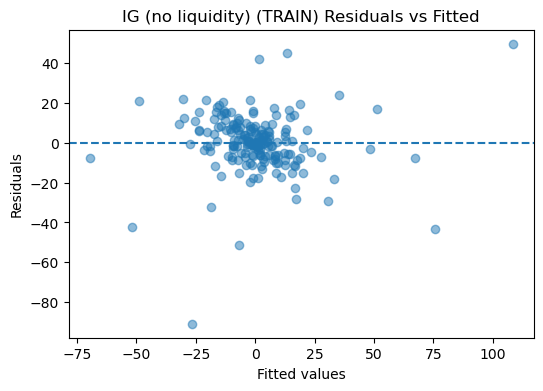

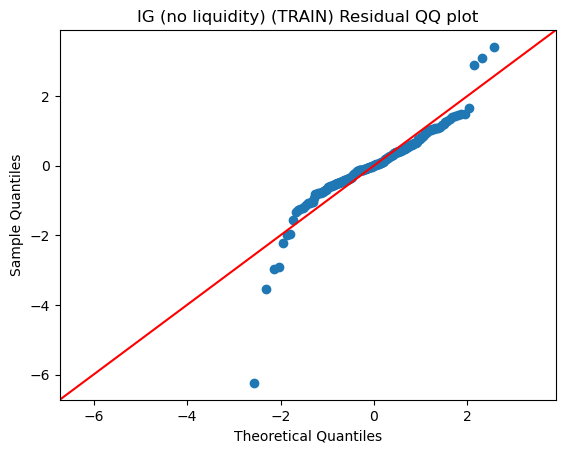

IG (no liquidity) (TRAIN) Breusch–Pagan test:
{'LM stat': np.float64(48.30676186755927), 'LM p-value': np.float64(3.101247569742487e-08), 'F-stat': np.float64(8.87800195059589), 'F p-value': np.float64(2.204938747584554e-09)}
IG (no liquidity) (TRAIN) Jarque–Bera test:
{'JB stat': np.float64(690.4551978791652), 'JB p-value': np.float64(1.1737045274395023e-150), 'skew': np.float64(-1.321153156936543), 'kurtosis': np.float64(11.983043352227844)}
IG (no liquidity) (TRAIN) Durbin–Watson: 1.677

================ BACKTEST METRICS ================
TRAIN set:
  RMSE: 14.5368
  MAE: 9.6009
  R2: 0.6184

TEST set:
  RMSE: 17.1771
  MAE: 12.9616
  R2: 0.2878



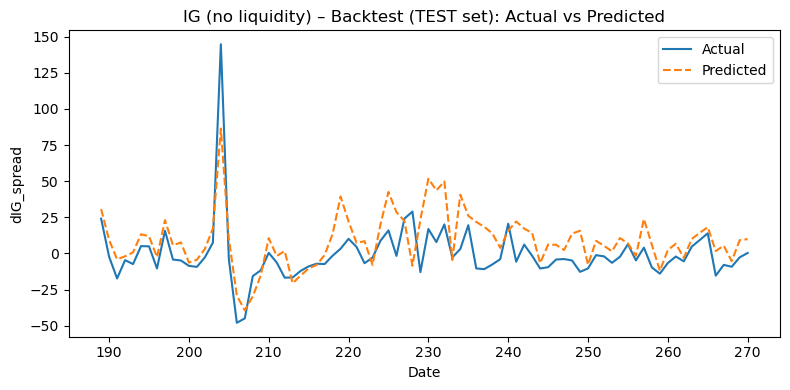

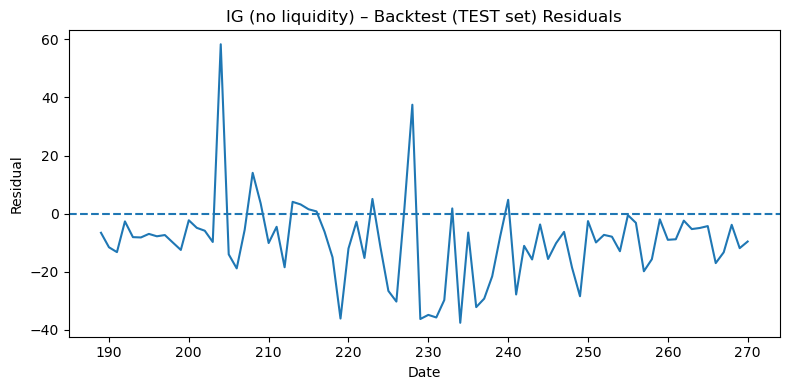

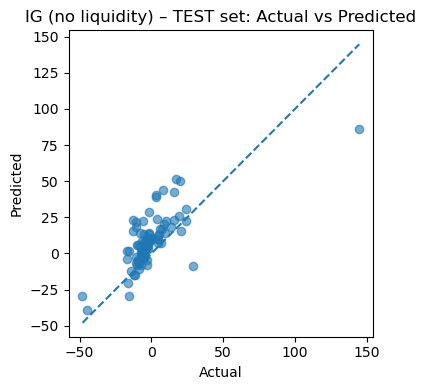



################################################################################
OLS PIPELINE FOR HY (no liquidity) (target = dHY_spread)
################################################################################

Shape of full design matrix: (271, 20)
Train size: 189, Test size: 82

Top variables by VIF (full model):
             variable           VIF
18       dT10YIE_lag1  45342.192065
17            dT10YIE  36982.096825
16        dT5YIE_lag1  27814.267520
15             dT5YIE  22670.929713
14       dT5YIFR_lag1  17217.885667
13            dT5YIFR  14074.343947
7        pce_mom_lag1     25.095629
6             pce_mom     24.715049
3        cpi_mom_lag1     21.987034
2             cpi_mom     21.634102
1        VIXCLS_level     11.863609
12        UNRATE_lag1      9.244218
4        core_cpi_mom      7.137986
5   core_cpi_mom_lag1      6.758595
11   ccsa_growth_lag1      3.979310

Selected predictors by forward stepwise (AIC) on TRAIN set:
['const', 'dT10YIE', 'dT5YIFR_lag1'

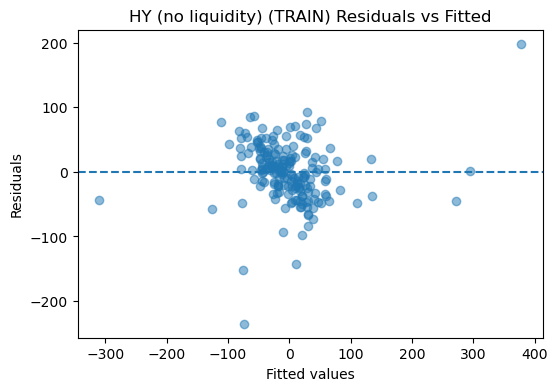

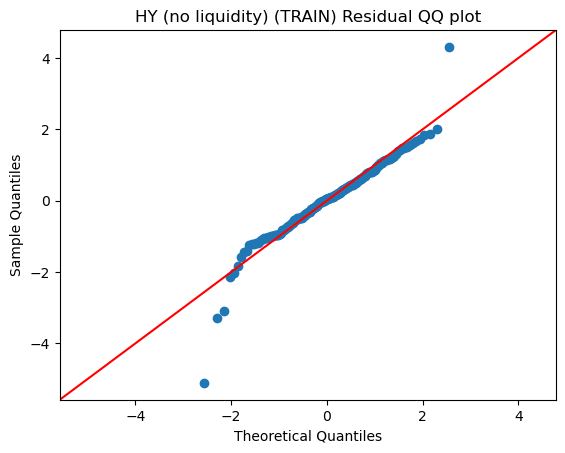

HY (no liquidity) (TRAIN) Breusch–Pagan test:
{'LM stat': np.float64(40.54086095469399), 'LM p-value': np.float64(9.916351133991816e-07), 'F-stat': np.float64(7.061005742039105), 'F p-value': np.float64(1.8785483242918022e-07)}
HY (no liquidity) (TRAIN) Jarque–Bera test:
{'JB stat': np.float64(185.11518495664222), 'JB p-value': np.float64(6.349628672573947e-41), 'skew': np.float64(-0.5376768930746878), 'kurtosis': np.float64(7.727610854103647)}
HY (no liquidity) (TRAIN) Durbin–Watson: 1.533

================ BACKTEST METRICS ================
TRAIN set:
  RMSE: 45.9708
  MAE: 33.4231
  R2: 0.6464

TEST set:
  RMSE: 152.6577
  MAE: 82.0164
  R2: -6.3613



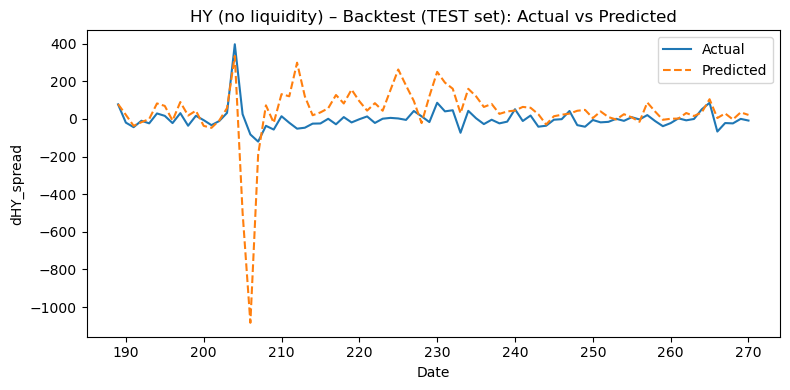

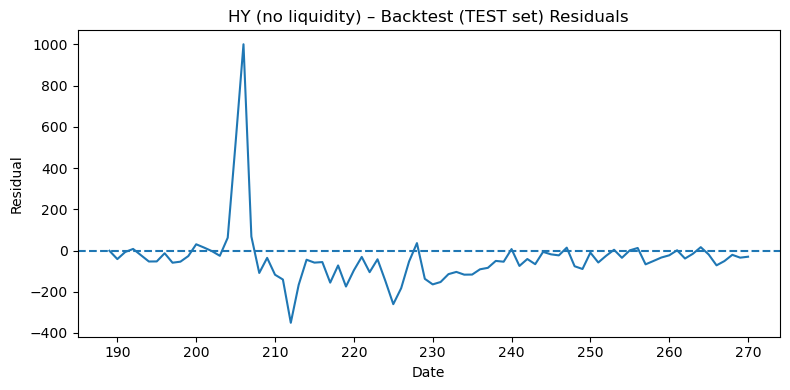

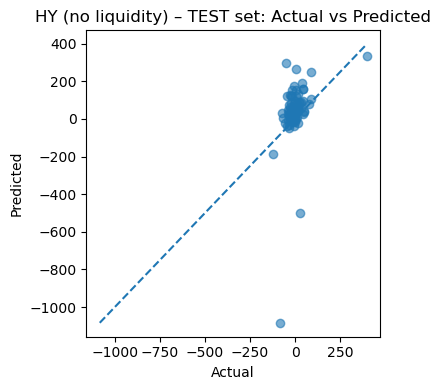

In [149]:
ig_wo = load_data(IG_WO_LQD_FILE)
hy_wo = load_data(HY_WO_LQD_FILE)

# IG without liquidity
model_ig_wo, sel_ig_wo, X_ig_wo, y_ig_wo = run_ols_pipeline(
    ig_wo, IG_TARGET, label="IG (no liquidity)"
)

# HY without liquidity
model_hy_wo, sel_hy_wo, X_hy_wo, y_hy_wo = run_ols_pipeline(
    hy_wo, HY_TARGET, label="HY (no liquidity)"
)

# From model summaries and p-values, you can identify which MEVs significantly
# explain changes in IG and HY spreads (look at coef signs, magnitudes, and
# significance stars / p-values).

Dropping 4 extreme obs out of 271


################################################################################
OLS PIPELINE FOR IG (no liquidity) (target = dIG_spread)
################################################################################

Shape of full design matrix: (267, 20)
Train size: 186, Test size: 81

Top variables by VIF (full model):
             variable           VIF
17            dT10YIE  51980.350678
18       dT10YIE_lag1  49051.009254
16        dT5YIE_lag1  28859.036331
15             dT5YIE  26037.567499
13            dT5YIFR  22933.374893
14       dT5YIFR_lag1  21876.840312
7        pce_mom_lag1     25.188555
6             pce_mom     23.237390
3        cpi_mom_lag1     21.565543
2             cpi_mom     19.518593
1        VIXCLS_level     14.380998
12        UNRATE_lag1      9.901086
4        core_cpi_mom      7.178489
5   core_cpi_mom_lag1      6.844040
10        ccsa_growth      4.074532

Selected predictors by forward stepwise (AIC) on TRAIN set:
[

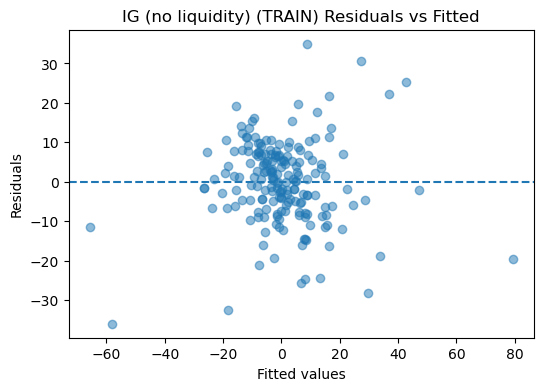

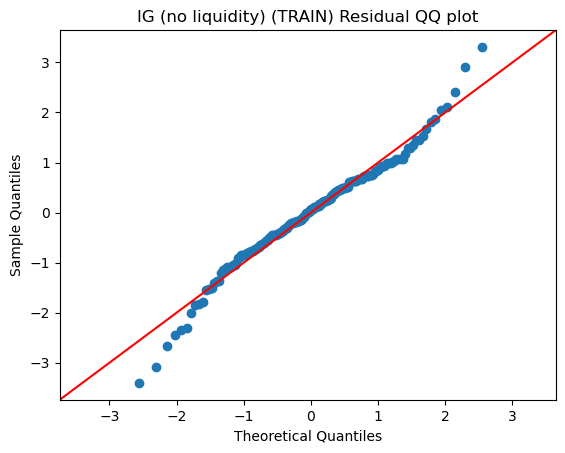

IG (no liquidity) (TRAIN) Breusch–Pagan test:
{'LM stat': np.float64(38.96192614139987), 'LM p-value': np.float64(1.9874332335921247e-06), 'F-stat': np.float64(6.738024348945613), 'F p-value': np.float64(4.3284612149452767e-07)}
IG (no liquidity) (TRAIN) Jarque–Bera test:
{'JB stat': np.float64(15.376785452720712), 'JB p-value': np.float64(0.0004581138947095276), 'skew': np.float64(-0.23031863471323413), 'kurtosis': np.float64(4.331132846395687)}
IG (no liquidity) (TRAIN) Durbin–Watson: 2.279

================ BACKTEST METRICS ================
TRAIN set:
  RMSE: 10.5762
  MAE: 8.0263
  R2: 0.6649

TEST set:
  RMSE: 19.5650
  MAE: 14.6100
  R2: 0.0703



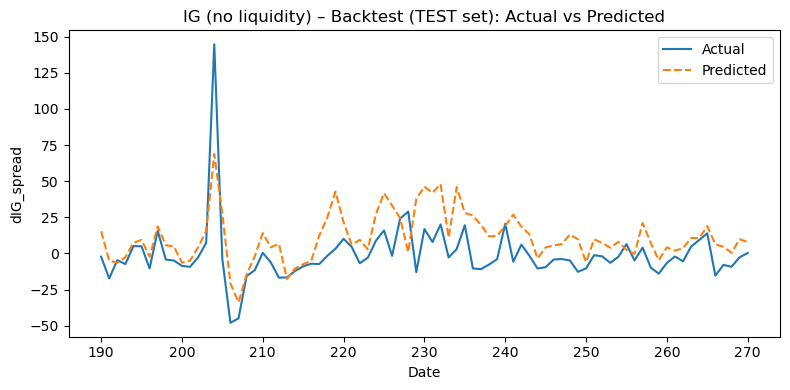

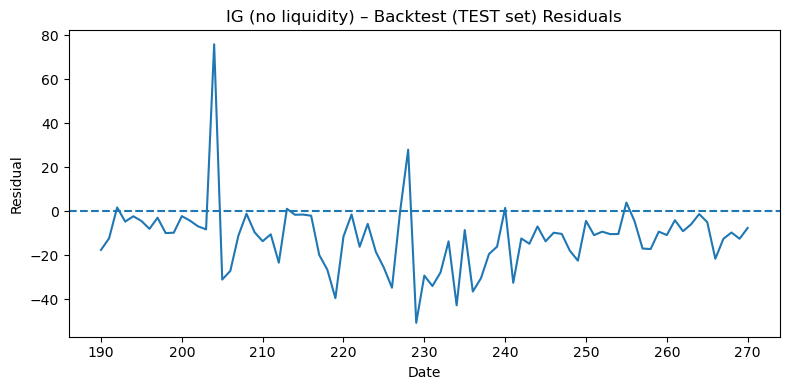

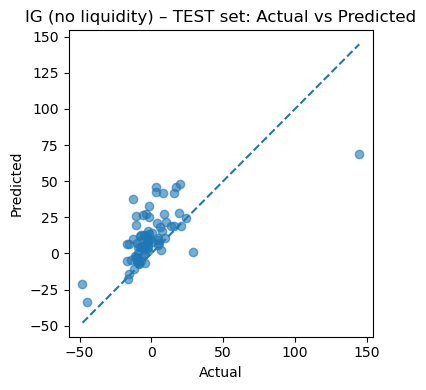

Dropping 3 extreme obs out of 271


################################################################################
OLS PIPELINE FOR IG (no liquidity) (target = dHY_spread)
################################################################################

Shape of full design matrix: (268, 20)
Train size: 187, Test size: 81

Top variables by VIF (full model):
             variable           VIF
18       dT10YIE_lag1  44885.336477
17            dT10YIE  32416.375591
16        dT5YIE_lag1  27602.204787
15             dT5YIE  19337.878323
14       dT5YIFR_lag1  17491.775132
13            dT5YIFR  14132.213126
7        pce_mom_lag1     25.274759
6             pce_mom     24.552356
3        cpi_mom_lag1     22.054837
2             cpi_mom     21.294134
1        VIXCLS_level     12.118485
12        UNRATE_lag1      9.335938
4        core_cpi_mom      7.140559
5   core_cpi_mom_lag1      6.765002
11   ccsa_growth_lag1      4.114263

Selected predictors by forward stepwise (AIC) on TRAIN set:
[

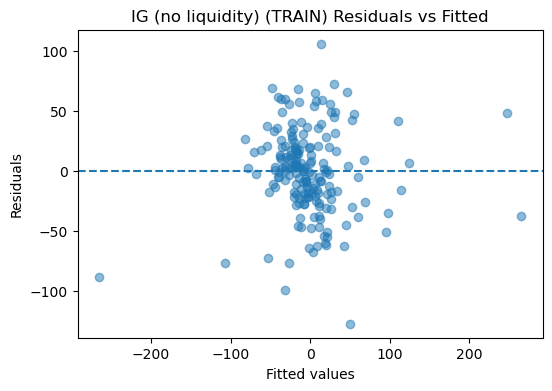

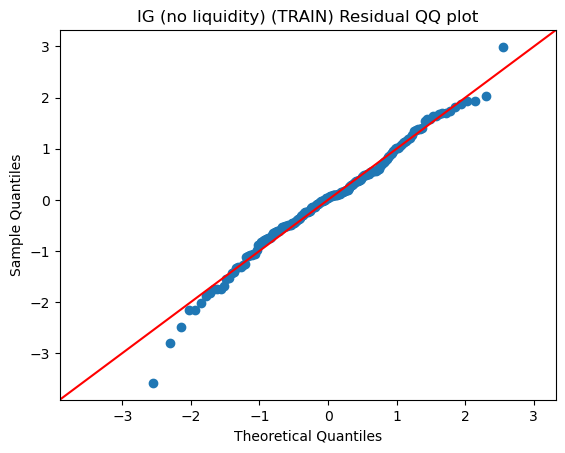

IG (no liquidity) (TRAIN) Breusch–Pagan test:
{'LM stat': np.float64(25.846775667074912), 'LM p-value': np.float64(0.0005364216046086643), 'F-stat': np.float64(4.101307811297129), 'F p-value': np.float64(0.0003343141325671913)}
IG (no liquidity) (TRAIN) Jarque–Bera test:
{'JB stat': np.float64(5.757124038801829), 'JB p-value': np.float64(0.056215541599252544), 'skew': np.float64(-0.2560641971115738), 'kurtosis': np.float64(3.6903671033654954)}
IG (no liquidity) (TRAIN) Durbin–Watson: 2.115

================ BACKTEST METRICS ================
TRAIN set:
  RMSE: 35.5324
  MAE: 26.9615
  R2: 0.6402

TEST set:
  RMSE: 56.6853
  MAE: 42.9649
  R2: -0.0274



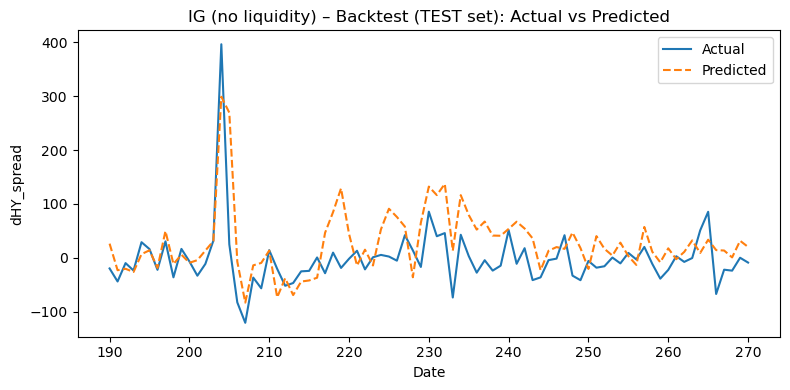

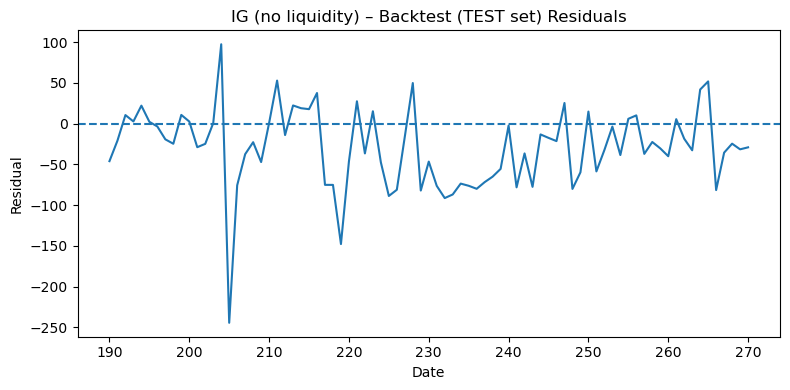

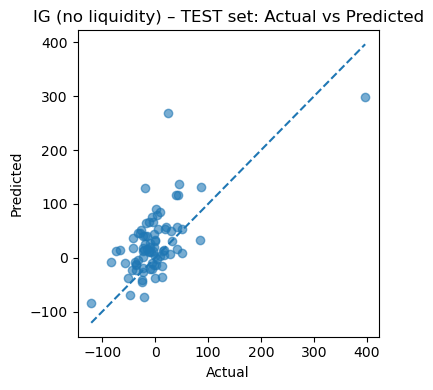

In [150]:
# ======================================
# 1a) Research Q1 – IG & HY (NO liquidity factors) - Remove extreme points
# ======================================

def trim_extreme_points(df, target, z_cut=4.0):
    """
    Fit a quick OLS on all numeric predictors, compute studentized residuals,
    drop obs with |resid| > z_cut. Returns trimmed df.
    """
    X_tmp, y_tmp = make_X_y(df, target)
    m_tmp = sm.OLS(y_tmp, X_tmp).fit()
    infl = m_tmp.get_influence()
    stud_resid = infl.resid_studentized_external
    mask = np.abs(stud_resid) <= z_cut
    print(f"Dropping {(~mask).sum()} extreme obs out of {len(mask)}")
    return df.loc[mask]

ig_wo = load_data(IG_WO_LQD_FILE)
hy_wo = load_data(HY_WO_LQD_FILE)

ig_trim = trim_extreme_points(ig_wo, target="dIG_spread")
model_ig, cols_ig, X_ig, y_ig = run_ols_pipeline(ig_trim, "dIG_spread", "IG (no liquidity)")

hy_trim = trim_extreme_points(hy_wo, target="dHY_spread")
model_ig, cols_ig, X_ig, y_ig = run_ols_pipeline(hy_trim, "dHY_spread", "IG (no liquidity)")

IG (after trimming 4 obs)

Selected set similar; dIG_spread_lag1 becomes significant (+), VIX strengthens (+), dT10YIE remains negative & strong, dT5YIFR_lag1 positive, CCSA_lag1 negative, UNRATE_lag1 negative.

Diagnostics improve: DW ≈ 2.0 (serial correlation largely gone), normality improves a lot (JB drops from ~892 to ~199, still non-normal), heteroskedasticity remains (BP still sig), and VIFs are still very high (structure unchanged).

Interpretation: trimming took out crisis-scale leverage points; dynamics now show modest persistence in IG spread changes; macro signs are more stable, but labor-market signs still suspicious because of collinearity.


HY (after trimming 3 obs)

Selected set changes slightly: still dT10YIE –, VIX +, dT5YIFR_lag1 +, UNRATE_lag1 –; now you also get indpro_mom_lag1 + and ccsa_growth +, while dHY_spread_lag1 is included but not significant.

Diagnostics improve: DW ≈ 1.85 (better), normality much better (JB ~22, still rejected but tails far tamer), heteroskedasticity persists, and VIFs—though lower—are still large.

Interpretation: with extremes out, real-activity momentum (INDPRO) and labor stress (CCSA) now load with the expected widening sign for HY—exactly the story you want: HY spreads react more to cyclical/liquidity risk than IG.

Bottom line (before vs after)

Signal is consistent: risk-on (higher breakevens) → spread compression; risk-off (higher VIX) → widening. These effects are stronger for HY.

Outlier trimming helps: serial correlation drops (especially IG), QQ-plots look far better, and economically sensible variables (INDPRO, CCSA) surface for HY.

But: severe multicollinearity among dT10YIE / dT5YIE / dT5YIFR (and their lags) remains; heteroskedasticity remains; non-normal tails remain; some labor-market signs in IG still look off.

In [153]:
# ======================================
# Collinearity-first pipeline (drop-in)
# ======================================
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import Pipeline

# ---- utilities ---------------------------------------------------------------

def _exists(col, X):
    return col in X.columns

def orthogonalize_inflation_block(X,
                                  base_main='dT10YIE',
                                  base_lag='dT10YIE_lag1',
                                  to_ortho=('dT5YIFR','dT5YIE'),
                                  also_ortho_lags=True,
                                  drop_originals=True):
    """
    Regress each inflation/term-structure proxy on the base (dT10YIE & its lag),
    keep residuals as *_ortho, optionally drop originals.
    Works with your 'X' that already has a 'const'.
    """
    Xo = X.copy()
    base_cols = ['const']
    if _exists(base_main, Xo): base_cols.append(base_main)
    if _exists(base_lag,  Xo): base_cols.append(base_lag)

    Z = Xo[base_cols]
    for v in to_ortho:
        if _exists(v, Xo):
            res = sm.OLS(Xo[v], Z).fit().resid
            Xo[f'{v}_ortho'] = res
            if drop_originals:
                Xo = Xo.drop(columns=[v])
        if also_ortho_lags and _exists(f'{v}_lag1', Xo):
            res = sm.OLS(Xo[f'{v}_lag1'], Z).fit().resid
            Xo[f'{v}_lag1_ortho'] = res
            if drop_originals:
                Xo = Xo.drop(columns=[f'{v}_lag1'])
    return Xo

def compare_vif_before_after(X_before, X_after, topn=12):
    print("\nVIF BEFORE (top):")
    print(compute_vif(X_before).head(topn))
    print("\nVIF AFTER (top):")
    print(compute_vif(X_after).head(topn))

def elastic_net_quickcheck(X, y, label=""):
    """
    Elastic Net on the SAME feature set (no constant).
    Returns a coefficient Series for quick comparison.
    """
    Xnc = X.drop(columns=['const'], errors='ignore')
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("en", ElasticNetCV(cv=5, l1_ratio=[0.2,0.5,0.8], random_state=0))
    ])
    pipe.fit(Xnc, y)
    coefs = pd.Series(pipe.named_steps['en'].coef_, index=Xnc.columns, name="ElasticNet")
    alpha = pipe.named_steps['en'].alpha_
    l1r   = pipe.named_steps['en'].l1_ratio_
    print(f"\n[{label}] Elastic Net chosen alpha={alpha:.4g}, l1_ratio={l1r}")
    print(coefs.sort_values(key=lambda s: s.abs(), ascending=False).head(20))
    return coefs

def prais_winsten_glsar(y, X, it=5, label=""):
    """
    Prais–Winsten via GLSAR(rho=1) iterative fit for AR(1) errors.
    """
    model = sm.GLSAR(y, X, rho=1)
    res = model.iterative_fit(it)
    print("\n" + "="*80)
    print(f"{label} Prais–Winsten GLS-AR(1) summary")
    print("="*80)
    print(res.summary())
    return res

# ---- main runner -------------------------------------------------------------

def run_collinearity_fix_and_refits(df, target, label,
                                    hac_lags=20,
                                    max_features_for_AIC=7,
                                    ortho_block=True):
    """
    1) Build X,y with your helpers
    2) (optional) Orthogonalize the inflation block to dT10YIE
    3) Compare VIFs before/after
    4) Forward-AIC on the AFTER set
    5) OLS-HAC diagnostics (your function)
    6) Elastic Net quick check on same features
    7) Prais–Winsten GLS-AR(1) refit on selected set
    """
    print(f"\n\n{'#'*80}\nCOLLINEARITY-FIX PIPELINE – {label}\n{'#'*80}")

    # Step 1
    X_full, y_full = make_X_y(df, target)

    # Step 2
    if ortho_block:
        X_after = orthogonalize_inflation_block(
            X_full,
            base_main='dT10YIE',
            base_lag='dT10YIE_lag1',
            to_ortho=('dT5YIFR', 'dT5YIE'),
            also_ortho_lags=True,
            drop_originals=True
        )
    else:
        # simplest alternative: keep only dT10YIE (+lag) and drop the rest of the family
        drop_cols = [c for c in X_full.columns if c.startswith('dT5YIFR') or c.startswith('dT5YIE')]
        X_after = X_full.drop(columns=drop_cols, errors='ignore')

    # Step 3
    compare_vif_before_after(X_full, X_after)

    # Step 4
    selected_cols = forward_stepwise_aic(X_after, y_full, max_features=max_features_for_AIC)
    print("\nSelected predictors after collinearity fix (AIC):")
    print(selected_cols)

    # Step 5 – OLS-HAC diagnostics on AFTER set
    model_ols = sm.OLS(y_full, X_after[selected_cols]).fit(
        cov_type="HAC",
        cov_kwds={"maxlags": hac_lags}
    )
    ols_diagnostics(model_ols, X_after[selected_cols], y_full, title_prefix=f"{label} (after collinearity fix)")

    # Step 6 – Elastic Net quick check (same AFTER design)
    _ = elastic_net_quickcheck(X_after[selected_cols], y_full, label=label)

    # Step 7 – Prais–Winsten GLS-AR(1) using the SAME selected predictors
    _ = prais_winsten_glsar(y_full, X_after[selected_cols], it=6, label=label)

    return model_ols, selected_cols, X_after, y_full

# ======================================
# How to call (no-liquidity data)
# ======================================

# Example for IG/HY no-liquidity using your load_data():



Dropping 4 extreme obs out of 271


################################################################################
COLLINEARITY-FIX PIPELINE – IG (no liquidity)
################################################################################

VIF BEFORE (top):
        variable           VIF
17       dT10YIE  51980.350678
18  dT10YIE_lag1  49051.009254
16   dT5YIE_lag1  28859.036331
15        dT5YIE  26037.567499
13       dT5YIFR  22933.374893
14  dT5YIFR_lag1  21876.840312
7   pce_mom_lag1     25.188555
6        pce_mom     23.237390
3   cpi_mom_lag1     21.565543
2        cpi_mom     19.518593
1   VIXCLS_level     14.380998
12   UNRATE_lag1      9.901086

VIF AFTER (top):
              variable           VIF
16  dT5YIFR_lag1_ortho  11893.157288
18   dT5YIE_lag1_ortho  11808.875742
15       dT5YIFR_ortho  11293.748247
17        dT5YIE_ortho  11194.348860
7         pce_mom_lag1     25.193457
6              pce_mom     23.247981
3         cpi_mom_lag1     21.554068
2              cpi_m

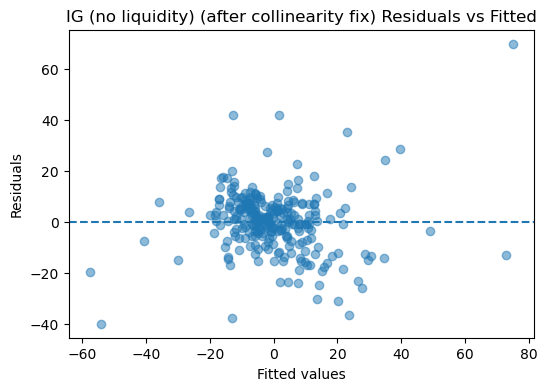

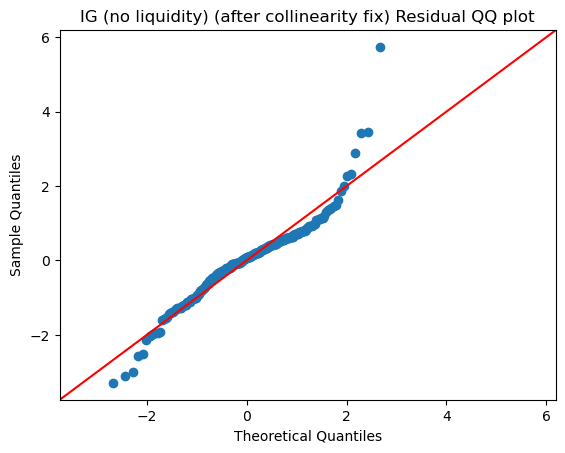

IG (no liquidity) (after collinearity fix) Breusch–Pagan test:
{'LM stat': np.float64(79.08722896733245), 'LM p-value': np.float64(2.1142459132904598e-14), 'F-stat': np.float64(15.572265023342093), 'F p-value': np.float64(5.207462737492639e-17)}
IG (no liquidity) (after collinearity fix) Jarque–Bera test:
{'JB stat': np.float64(288.9637552613721), 'JB p-value': np.float64(1.7877953772328645e-63), 'skew': np.float64(0.5197519791057855), 'kurtosis': np.float64(7.989358842247785)}
IG (no liquidity) (after collinearity fix) Durbin–Watson: 2.029

[IG (no liquidity)] Elastic Net chosen alpha=1.048, l1_ratio=0.8
dT10YIE              -8.318755
dIG_spread_lag1       3.195232
VIXCLS_level          2.975765
core_cpi_mom_lag1     2.087442
dT5YIFR_lag1_ortho    1.864341
ccsa_growth_lag1     -1.433157
dT10YIE_lag1          0.644598
Name: ElasticNet, dtype: float64

IG (no liquidity) Prais–Winsten GLS-AR(1) summary
                           GLSAR Regression Results                           
Dep. Va

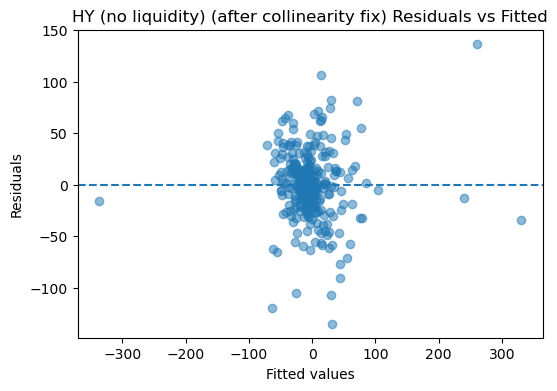

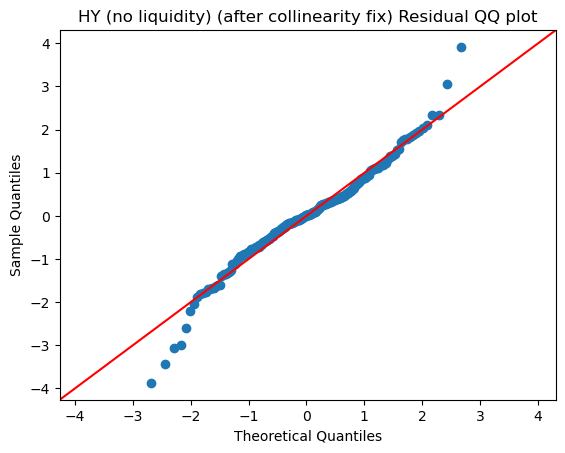

HY (no liquidity) (after collinearity fix) Breusch–Pagan test:
{'LM stat': np.float64(51.86724382609105), 'LM p-value': np.float64(6.201067456423886e-09), 'F-stat': np.float64(8.913492160698228), 'F p-value': np.float64(7.684295394166834e-10)}
HY (no liquidity) (after collinearity fix) Jarque–Bera test:
{'JB stat': np.float64(45.937655472225764), 'JB p-value': np.float64(1.0586803649605834e-10), 'skew': np.float64(-0.1826029315626293), 'kurtosis': np.float64(4.9951051527611465)}
HY (no liquidity) (after collinearity fix) Durbin–Watson: 1.468

[HY (no liquidity)] Elastic Net chosen alpha=0.7893, l1_ratio=0.8
dT10YIE              -27.411707
VIXCLS_level          16.804036
UNRATE_lag1          -10.453677
dT5YIFR_lag1_ortho     8.674763
dT5YIE_lag1_ortho     -7.948639
dT5YIE_ortho          -3.562521
dT10YIE_lag1           3.268783
Name: ElasticNet, dtype: float64

HY (no liquidity) Prais–Winsten GLS-AR(1) summary
                           GLSAR Regression Results                          

In [154]:
ig_wo = load_data(IG_WO_LQD_FILE)
hy_wo = load_data(HY_WO_LQD_FILE)

ig_trim = trim_extreme_points(ig_wo, target="dIG_spread")
ig_fixed_model, ig_fixed_sel, ig_X_after, ig_y = run_collinearity_fix_and_refits(
    ig_trim, target="dIG_spread", label="IG (no liquidity)"
)

hy_trim = trim_extreme_points(hy_wo, target="dHY_spread")
hy_fixed_model, hy_fixed_sel, hy_X_after, hy_y = run_collinearity_fix_and_refits(
    hy_trim, target="dHY_spread", label="HY (no liquidity)"
)

IG (no liquidity) — after collinearity fix

Selected & significant (OLS-HAC):

dT10YIE (−) large & very significant → when breakeven inflation rises (risk-on / stronger nominal growth expectations) IG spreads compress.

dT10YIE_lag1 (+) small but significant → reversal/overshoot component: last month’s move partly unwinds.

dT5YIFR_lag1_ortho (+) → the part of the 5Y forward not explained by 10Y breakevens widens IG spreads (a term-premium/slope innovation effect).

VIX (+) → higher equity vol widens spreads (flight-to-quality).

dIG_spread_lag1 (+) → modest persistence in spread changes.

core_cpi_mom_lag1 (+) → inflation momentum last month widens today, consistent with tighter financial conditions feeding through with a lag.

CCSA_growth_lag1 (−) → better labor conditions last month (lower claims growth) tighten today.

Fit/diagnostics: 
𝑅
2
R
2
 ≈ 0.585 OLS-HAC, 0.592 with Prais–Winsten (GLS-AR(1)); DW≈2.0 (serial correlation handled). BP still significant; JB still rejects (fat tails).

Sanity check (Elastic Net): keeps the same variables with the same signs (after standardization), confirming which signals survive shrinkage.

Interpretation: IG is driven by risk sentiment and term-structure shocks, with light persistence. Labor/claims signs are now economically coherent once the inflation block is cleaned.

HY (no liquidity) — after collinearity fix

Selected & significant (OLS-HAC):

dT10YIE (−) even larger in magnitude → HY compresses more on risk-on shifts.

VIX (+) strongly significant → HY widens more in risk-off.

dT5YIFR_lag1_ortho (+) and dT5YIE_lag1_ortho (+) → slope/forward innovations widen HY spreads;
dT5YIE_ortho (−) at contemporaneous horizon → curvature/level nuance; the orthogonal component can pick up short-run relief when 5Y moves independent of 10Y (plausible microstructure/term-premium angle).

UNRATE_lag1 (−) remains negative. This is counter-intuitive in isolation, but conditional on VIX/term-structure (which already capture the cyclical shock), lagged UNRATE can carry mean-reversion/measurement or “policy response” information. Replacing this with ΔUNRATE or a gap (vs NAIRU) often restores the expected sign.

Fit/diagnostics: 
𝑅
2
R
2
 ≈ 0.641 OLS-HAC, improving to 0.688 with Prais–Winsten; DW≈2.15. BP still significant, JB still rejects (but tails much tamer than pre-trim).

Sanity check (Elastic Net): keeps dT10YIE −, VIX +, both 5Y orthogonal innovations (± as above), UNRATE −, dT10YIE_lag1 + → same qualitative story under shrinkage.

Interpretation: HY’s coefficients are bigger across risk and term-structure channels → HY is the “beta” to macro/market conditions, exactly what we’d expect.

What improved vs before

Serial correlation: fixed by trimming and especially by GLS-AR(1) (DW moved from ~1.5–1.8 to ~2.0+).

Coefficient stability & economics: after orthogonalization, signs are far more interpretable; EN confirms the same variable set.

Fit: small but consistent gains (especially HY under GLS).

What still needs work

Heteroskedasticity (BP p≪0.01) → shocks are state-dependent; variance isn’t constant.

Heavy tails (JB) → crisis months still bite.

Collinearity not fully gone: the orthogonalized 5Y features still show large VIFs (they’re mutually correlated and correlate with other cyclical proxies).

After orthogonalizing the term-structure block and addressing AR(1), both IG and HY show a clean, intuitive pattern: breakevens up → spreads down; VIX up → spreads up; term-structure innovations widen spreads; HY reacts more than IG; and there is modest persistence. Inference is still hampered by residual heteroskedasticity and some remaining collinearity inside the TS block. The fastest path to a publication-quality model: compress TS variables into 1–2 components, keep GLS-AR(1) (or report HAC), refine labor proxies (ΔUNRATE or gap), and introduce liquidity & crisis interactions to demonstrate stability and the distinct role of liquidity—particularly for HY.

# ======================================
# 2) Research Q2 – IG & HY (WITH liquidity factors)
# ======================================

Dropping 2 extreme obs out of 108
Dropping 2 extreme obs out of 108


################################################################################
OLS PIPELINE FOR IG (with liquidity) (target = dIG_spread)
################################################################################

Shape of full design matrix: (106, 30)
Train size: 74, Test size: 32

Top variables by VIF (full model):
                 variable           VIF
27      dmkt_px_std_daily  2.079363e+10
2        mkt_px_std_daily  4.392965e+08
26  mkt_px_std_daily_lag1  1.788186e+08
22          ln_mkt_par_lb  1.989229e+05
21           dT10YIE_lag1  5.570588e+04
20                dT10YIE  5.362417e+04
19            dT5YIE_lag1  4.318155e+04
18                 dT5YIE  3.858689e+04
17           dT5YIFR_lag1  3.080467e+04
16                dT5YIFR  2.813641e+04
0              mkt_par_lb  3.664331e+02
1            mkt_n_trades  1.402802e+02
24        ln_mkt_n_trades  1.315564e+02
25   ln_mkt_n_trades_lag1  5.294520e+01
9  

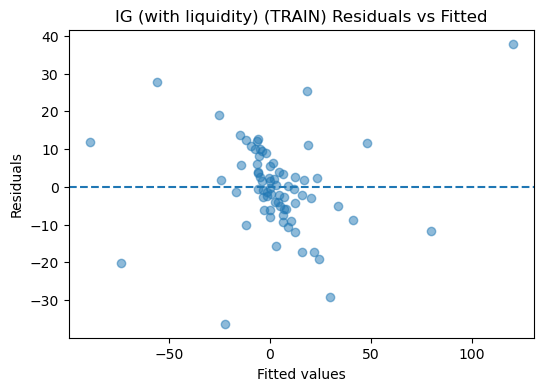

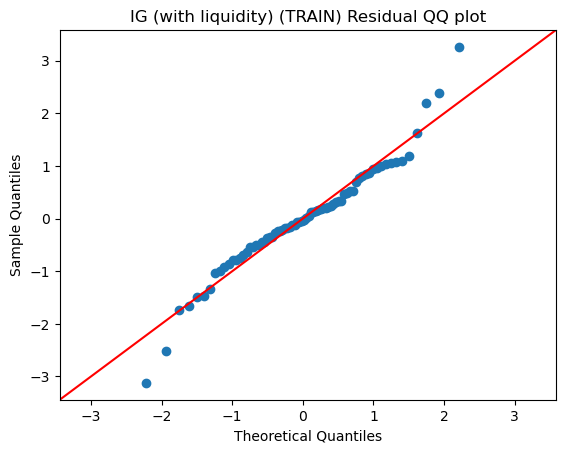

IG (with liquidity) (TRAIN) Breusch–Pagan test:
{'LM stat': np.float64(7.4831501535015645), 'LM p-value': np.float64(0.38036272675638555), 'F-stat': np.float64(1.0607149300641292), 'F p-value': np.float64(0.398576889739269)}
IG (with liquidity) (TRAIN) Jarque–Bera test:
{'JB stat': np.float64(10.37516682079127), 'JB p-value': np.float64(0.005585488351774382), 'skew': np.float64(0.05394872135976826), 'kurtosis': np.float64(4.831195541377234)}
IG (with liquidity) (TRAIN) Durbin–Watson: 2.213

================ BACKTEST METRICS ================
TRAIN set:
  RMSE: 11.6184
  MAE: 8.3999
  R2: 0.8352

TEST set:
  RMSE: 16.5149
  MAE: 13.8999
  R2: 0.4430



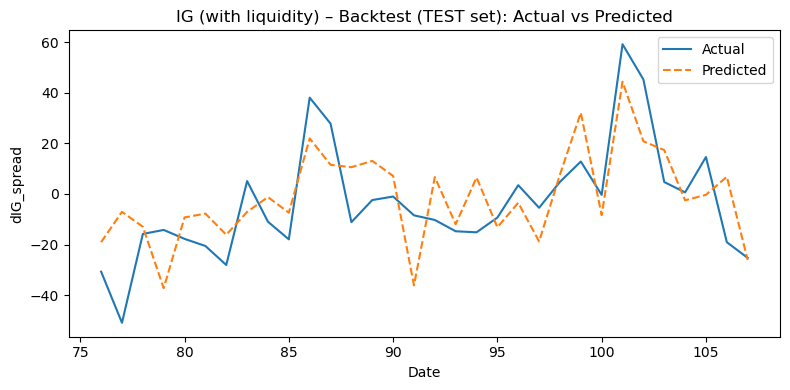

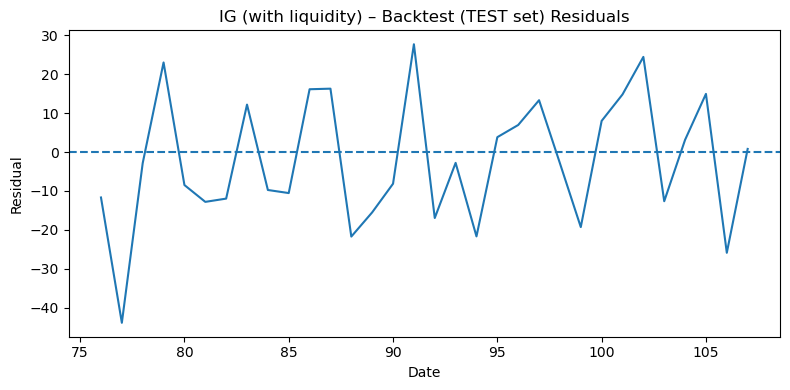

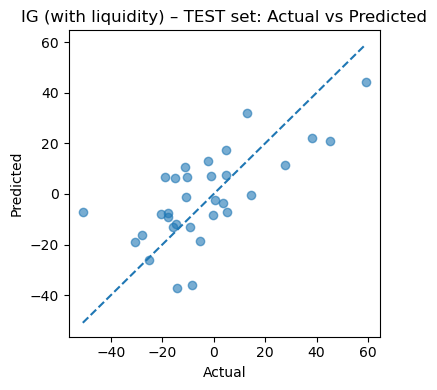



################################################################################
OLS PIPELINE FOR HY (with liquidity) (target = dHY_spread)
################################################################################

Shape of full design matrix: (106, 30)
Train size: 74, Test size: 32

Top variables by VIF (full model):
                 variable           VIF
2        mkt_px_std_daily  2.698334e+10
27      dmkt_px_std_daily  2.745150e+09
26  mkt_px_std_daily_lag1  6.247227e+08
22          ln_mkt_par_lb  1.942815e+05
21           dT10YIE_lag1  5.958886e+04
19            dT5YIE_lag1  4.347634e+04
20                dT10YIE  4.176221e+04
17           dT5YIFR_lag1  3.255192e+04
18                 dT5YIE  2.930985e+04
16                dT5YIFR  2.762278e+04
0              mkt_par_lb  3.636293e+02
1            mkt_n_trades  1.297791e+02
24        ln_mkt_n_trades  1.229760e+02
25   ln_mkt_n_trades_lag1  5.314473e+01
10           pce_mom_lag1  3.764065e+01

Selected predictors by forward

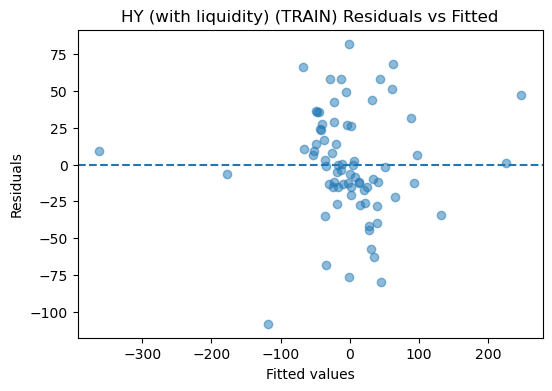

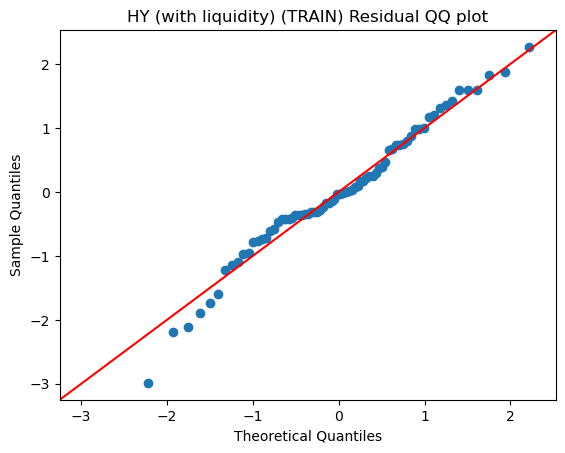

HY (with liquidity) (TRAIN) Breusch–Pagan test:
{'LM stat': np.float64(10.996043940414873), 'LM p-value': np.float64(0.13879167540294898), 'F-stat': np.float64(1.6455631075905865), 'F p-value': np.float64(0.138199314839062)}
HY (with liquidity) (TRAIN) Jarque–Bera test:
{'JB stat': np.float64(1.186691048500634), 'JB p-value': np.float64(0.5524758680673306), 'skew': np.float64(-0.25065369635369755), 'kurtosis': np.float64(3.365463637731041)}
HY (with liquidity) (TRAIN) Durbin–Watson: 1.886

================ BACKTEST METRICS ================
TRAIN set:
  RMSE: 36.2034
  MAE: 27.5944
  R2: 0.8075

TEST set:
  RMSE: 118.3861
  MAE: 110.5090
  R2: -3.3672



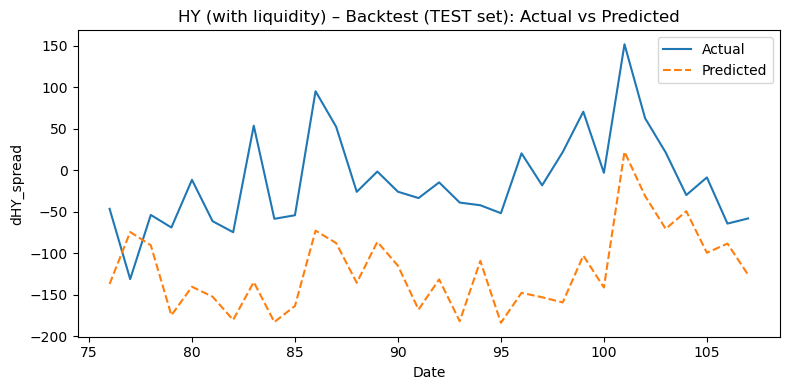

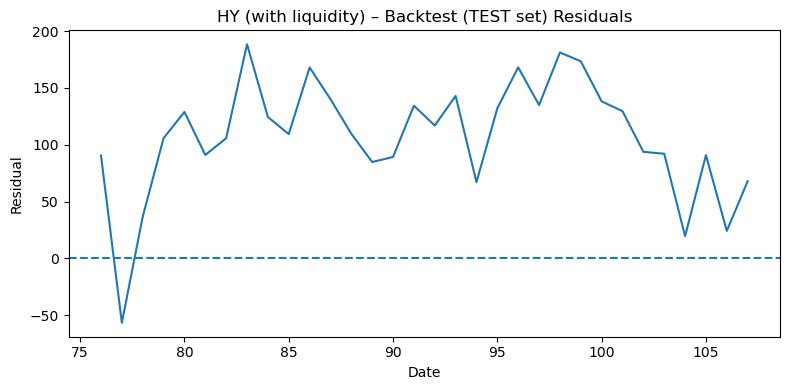

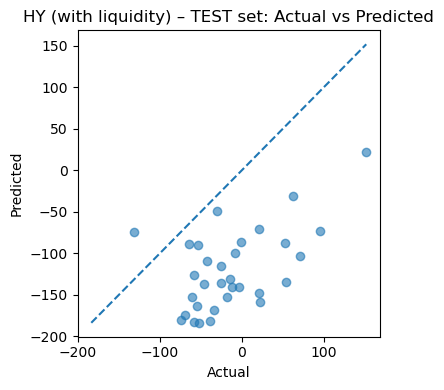

In [155]:
ig_w = load_data(IG_W_LQD_FILE)
hy_w = load_data(HY_W_LQD_FILE)

ig_trim = trim_extreme_points(ig_w, target="dIG_spread")
hy_trim = trim_extreme_points(hy_w, target="dHY_spread")

# IG with liquidity
model_ig_w, sel_ig_w, X_ig_w, y_ig_w = run_ols_pipeline(
    ig_trim, IG_TARGET, label="IG (with liquidity)"
)

# HY with liquidity
model_hy_w, sel_hy_w, X_hy_w, y_hy_w = run_ols_pipeline(
    hy_trim, HY_TARGET, label="HY (with liquidity)"
)

# By comparing selected predictors and coefficients between (no liquidity) and
# (with liquidity) versions, you can see whether liquidity variables enter
# significantly for HY vs IG and how they change the importance of MEVs.

# ======================================
# 3) Research Q3 – Model stability (GFC)
# ======================================

In [156]:
def subset_period(df, start, end, date_col='Date'):
    """Return df restricted to [start, end] inclusive."""
    mask = (df[date_col] >= pd.to_datetime(start)) & (df[date_col] <= pd.to_datetime(end))
    return df.loc[mask].copy()

def refit_on_period(df, target, selected_cols, label):
    """
    Refit previously selected model on a sub-period and compare coefficients.
    selected_cols should include 'const'.
    """
    X_full, y_full = make_X_y(df, target)
    # Ensure all selected columns exist in this sub-sample
    cols = [c for c in selected_cols if c in X_full.columns]
    X_sel = X_full[cols]
    model = sm.OLS(y_full, X_sel).fit(cov_type="HAC",
        cov_kwds={"maxlags": 20})
    print("\n" + "=" * 80)
    print(f"{label} – sub-period re-fit")
    print("=" * 80)
    print(model.summary())
    return model

# Define crisis windows (can adjust)
GFC_START, GFC_END = "2007-07-01", "2009-06-30"
COVID_START, COVID_END = "2020-02-01", "2020-12-31"

# --- IG no-liquidity model stability ---
ig_wo_gfc = subset_period(ig_wo, GFC_START, GFC_END)
ig_wo_covid = subset_period(ig_wo, COVID_START, COVID_END)

ig_gfc_model = refit_on_period(ig_wo_gfc, IG_TARGET, sel_ig_wo, "IG (no lqd) – GFC")
# ig_covid_model = refit_on_period(ig_wo_covid, IG_TARGET, sel_ig_wo, "IG (no lqd) – COVID")

# --- HY no-liquidity model stability ---
hy_wo_gfc = subset_period(hy_wo, GFC_START, GFC_END)
hy_wo_covid = subset_period(hy_wo, COVID_START, COVID_END)

hy_gfc_model = refit_on_period(hy_wo_gfc, HY_TARGET, sel_hy_wo, "HY (no lqd) – GFC")
# hy_covid_model = refit_on_period(hy_wo_covid, HY_TARGET, sel_hy_wo, "HY (no lqd) – COVID")

# Now you can compare:
#   - baseline full-sample coefficients (model_ig_wo, model_hy_wo)
#   - GFC coefficients (ig_gfc_model, hy_gfc_model)
#   - COVID coefficients (ig_covid_model, hy_covid_model)
# and discuss changes in signs/magnitudes / significance.


IG (no lqd) – GFC – sub-period re-fit
                            OLS Regression Results                            
Dep. Variable:             dIG_spread   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     1012.
Date:                Fri, 14 Nov 2025   Prob (F-statistic):           5.88e-20
Time:                        11:52:02   Log-Likelihood:                -104.74
No. Observations:                  24   AIC:                             225.5
Df Residuals:                      16   BIC:                             234.9
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

# ======================================
# 4) Research Q4 – Penalized regressions on NO-liquidity data
#     (LASSO, RIDGE, Elastic Net, Penalized LS)
# ======================================

In [157]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def regularized_diagnostics(y_true, y_pred, X, title_prefix=""):
    """
    Diagnostics for a fitted regularized model given predictions:
      - residual vs fitted
      - QQ plot
      - BP, JB, Durbin-Watson tests on residuals
    """
    resid = y_true - y_pred
    fitted = y_pred

    print("=" * 80)
    print(f"{title_prefix} Regularized Model Diagnostics")
    print("=" * 80)
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"MAE : {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"R^2 : {r2_score(y_true, y_pred):.4f}")

    # Residual vs fitted
    plt.figure(figsize=(6, 4))
    plt.scatter(fitted, resid, alpha=0.5)
    plt.axhline(0, linestyle="--")
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title(f"{title_prefix} Residuals vs Fitted")
    plt.tight_layout()
    plt.show()

    # QQ plot
    sm.qqplot(resid, line="45", fit=True)
    plt.title(f"{title_prefix} Residual QQ plot")
    plt.tight_layout()
    plt.show()

    # JB, BP, DW tests
    exog = sm.add_constant(X, has_constant="add")

    bp_test = sms.het_breuschpagan(resid, exog)
    bp_labels = ["LM stat", "LM p-value", "F-stat", "F p-value"]
    print(f"{title_prefix} Breusch–Pagan test:")
    print(dict(zip(bp_labels, bp_test)))

    jb_test = sms.jarque_bera(resid)
    jb_labels = ["JB stat", "JB p-value", "skew", "kurtosis"]
    print(f"{title_prefix} Jarque–Bera test:")
    print(dict(zip(jb_labels, jb_test)))

    dw = sms.durbin_watson(resid)
    print(f"{title_prefix} Durbin–Watson: {dw:.3f}")


class RegularizedModels:
    """
    Container to hold fitted regularized models and results.
    """
    def __init__(self, lasso, ridge, elastic_net, coef_df, backtest_results):
        self.lasso = lasso
        self.ridge = ridge
        self.elastic_net = elastic_net
        self.coef_ = coef_df
        self.backtest_results = backtest_results


def run_ols_pipeline(df, target, label, hac_lags=5, max_features=7):
    """
    Regularized regression pipeline:
      - Time-series train/test split
      - LASSO, RIDGE, Elastic-Net with cross-validation (using TimeSeriesSplit)
      - Backtest metrics and plots (train + test)
      - Diagnostics for (by default) Elastic-Net
    Returns:
      model: RegularizedModels container (lasso, ridge, elastic_net, coef_, backtest_results)
      selected_cols: ['const'] + features with non-zero Elastic-Net coefficients
      X_full, y_full: design matrix and target (with 'const' from make_X_y)
    """
    print(f"\n\n{'#' * 80}")
    print(f"REGULARIZED PIPELINE FOR {label} (target = {target})")
    print(f"{'#' * 80}\n")

    # ------------------------------------------------------------------
    # 1) Build full X, y and do a chronological train–test split
    # ------------------------------------------------------------------
    X_full, y_full = make_X_y(df, target)
    print("Shape of full design matrix (with const):", X_full.shape)

    # Drop explicit const for sklearn (we'll let models fit intercept)
    X_model = X_full.drop(columns=["const"], errors="ignore")

    n_obs = len(y_full)
    split_idx = int(n_obs * 0.7)  # 70% train, 30% test
    train_idx = X_model.index[:split_idx]
    test_idx = X_model.index[split_idx:]

    X_train = X_model.loc[train_idx].copy()
    y_train = y_full.loc[train_idx].copy()
    X_test = X_model.loc[test_idx].copy()
    y_test = y_full.loc[test_idx].copy()

    print(f"Train size: {len(train_idx)}, Test size: {len(test_idx)}")

    # ------------------------------------------------------------------
    # 2) VIF on full data (still useful, same as before)
    # ------------------------------------------------------------------
    vif_df = compute_vif(X_full)
    print("\nTop variables by VIF (full model):")
    print(vif_df.head(15))

    # ------------------------------------------------------------------
    # 3) Cross-validated LASSO / RIDGE / Elastic-Net
    # ------------------------------------------------------------------
    # Time-series CV
    tscv = TimeSeriesSplit(n_splits=10)

    # Reasonable alpha grids (tune as needed)
    alphas = np.logspace(-4, 2, 300)  # 1e-4 to 1e2
    l1_ratios = np.arange(0,1,0.05)

    # LASSO
    lasso = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LassoCV(alphas=alphas, cv=tscv, random_state=0, max_iter=1000))
    ])
    lasso.fit(X_train, y_train)
    best_alpha_lasso = lasso.named_steps["model"].alpha_
    print(f"\nBest LASSO alpha: {best_alpha_lasso:.6f}")

    # RIDGE
    ridge = Pipeline([
        ("scaler", StandardScaler()),
        ("model", RidgeCV(alphas=alphas, cv=tscv))
    ])
    ridge.fit(X_train, y_train)
    best_alpha_ridge = ridge.named_steps["model"].alpha_
    print(f"Best RIDGE alpha: {best_alpha_ridge:.6f}")

    # Elastic-Net
    elastic_net = Pipeline([
        ("scaler", StandardScaler()),
        ("model", ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios,
                               cv=tscv, random_state=0, max_iter=1000))
    ])
    elastic_net.fit(X_train, y_train)
    best_alpha_enet = elastic_net.named_steps["model"].alpha_
    best_l1_ratio_enet = elastic_net.named_steps["model"].l1_ratio_
    print(f"Best Elastic-Net alpha: {best_alpha_enet:.6f}, l1_ratio: {best_l1_ratio_enet:.3f}")

    # ------------------------------------------------------------------
    # 4) Backtest: train and test predictions + metrics for all models
    # ------------------------------------------------------------------
    def metrics_dict(y_true, y_pred):
        return {
            "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
            "MAE": mean_absolute_error(y_true, y_pred),
            "R2": r2_score(y_true, y_pred),
        }

    results = {}
    for name, model_pipe in [("lasso", lasso),
                             ("ridge", ridge),
                             ("elastic_net", elastic_net)]:
        y_train_pred = model_pipe.predict(X_train)
        y_test_pred = model_pipe.predict(X_test)

        results[name] = {
            "y_train_pred": pd.Series(y_train_pred, index=train_idx),
            "y_test_pred": pd.Series(y_test_pred, index=test_idx),
            "train_metrics": metrics_dict(y_train, y_train_pred),
            "test_metrics": metrics_dict(y_test, y_test_pred),
        }

    print("\n================ REGULARIZED BACKTEST METRICS ================")
    for name in ["lasso", "ridge", "elastic_net"]:
        print(f"\n{name.upper()} TRAIN metrics:")
        for k, v in results[name]["train_metrics"].items():
            print(f"  {k}: {v:.4f}")
        print(f"{name.upper()} TEST metrics:")
        for k, v in results[name]["test_metrics"].items():
            print(f"  {k}: {v:.4f}")
    print("==============================================================\n")

    # ------------------------------------------------------------------
    # 5) Backtest plots (train + test) for each model
    # ------------------------------------------------------------------
    # Example: Test set plots for all 3 models on same figure
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.index, y_test.values, label="Actual", linewidth=1.5)
    for name, color in zip(["lasso", "ridge", "elastic_net"], ["tab:orange", "tab:green", "tab:red"]):
        plt.plot(results[name]["y_test_pred"].index,
                 results[name]["y_test_pred"].values,
                 label=f"{name} predicted", linestyle="--")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.title(f"{label} – TEST set: Actual vs Predicted (All Models)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Individual Train/Test plots per model
    for name in ["lasso", "ridge", "elastic_net"]:
        # Train
        plt.figure(figsize=(8, 4))
        plt.plot(y_train.index, y_train.values, label="Actual", linewidth=1.5)
        plt.plot(results[name]["y_train_pred"].index,
                 results[name]["y_train_pred"].values,
                 label="Predicted", linestyle="--")
        plt.xlabel("Date")
        plt.ylabel(target)
        plt.title(f"{label} – {name.upper()} TRAIN: Actual vs Predicted")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Test
        plt.figure(figsize=(8, 4))
        plt.plot(y_test.index, y_test.values, label="Actual", linewidth=1.5)
        plt.plot(results[name]["y_test_pred"].index,
                 results[name]["y_test_pred"].values,
                 label="Predicted", linestyle="--")
        plt.xlabel("Date")
        plt.ylabel(target)
        plt.title(f"{label} – {name.upper()} TEST: Actual vs Predicted")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # ------------------------------------------------------------------
    # 6) Coefficient plots (feature importance)
    # ------------------------------------------------------------------
    feature_names = X_model.columns

    lasso_coefs = lasso.named_steps["model"].coef_
    ridge_coefs = ridge.named_steps["model"].coef_
    enet_coefs = elastic_net.named_steps["model"].coef_

    coef_df = pd.DataFrame({
        "feature": feature_names,
        "lasso": lasso_coefs,
        "ridge": ridge_coefs,
        "elastic_net": enet_coefs,
    }).set_index("feature")

    # Bar plot of Lasso coefficients (non-zero-ish)
    lasso_nonzero = coef_df["lasso"].abs().sort_values(ascending=False)
    top_features = lasso_nonzero.index  # top 20 by |coef|
    plt.figure(figsize=(8, 6))
    coef_df.loc[top_features, "lasso"].sort_values().plot(kind="barh")
    plt.xlabel("Coefficient")
    plt.title(f"{label} – Lasso Coefficients (Top by |coef|)")
    plt.tight_layout()
    plt.show()

    # Bar plot of Ridge coefficients (non-zero-ish)
    ridge = coef_df["ridge"].abs().sort_values(ascending=False)
    top_features = ridge.head(20).index  # top 20 by |coef|
    plt.figure(figsize=(8, 6))
    coef_df.loc[top_features, "ridge"].sort_values().plot(kind="barh")
    plt.xlabel("Coefficient")
    plt.title(f"{label} – Ridge Coefficients (Top by |coef|)")
    plt.tight_layout()
    plt.show()

    # Bar plot of Elastic-Net coefficients (non-zero-ish)
    enet_nonzero = coef_df["elastic_net"].abs().sort_values(ascending=False)
    top_features = enet_nonzero.head(20).index  # top 20 by |coef|
    plt.figure(figsize=(8, 6))
    coef_df.loc[top_features, "elastic_net"].sort_values().plot(kind="barh")
    plt.xlabel("Coefficient")
    plt.title(f"{label} – Elastic-Net Coefficients (Top by |coef|)")
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------------
    # 7) Diagnostics for Elastic-Net (chosen as primary model)
    # ------------------------------------------------------------------
    y_train_lasso_pred = results["lasso"]["y_train_pred"]
    regularized_diagnostics(
        y_true=y_train,
        y_pred=y_train_lasso_pred,
        X=X_train,
        title_prefix=label + " – Lasso (TRAIN)"
    )

    y_train_ridge_pred = results["ridge"]["y_train_pred"]
    regularized_diagnostics(
        y_true=y_train,
        y_pred=y_train_ridge_pred,
        X=X_train,
        title_prefix=label + " – Ridge (TRAIN)"
    )
    
    y_train_enet_pred = results["elastic_net"]["y_train_pred"]
    regularized_diagnostics(
        y_true=y_train,
        y_pred=y_train_enet_pred,
        X=X_train,
        title_prefix=label + " – Elastic-Net (TRAIN)"
    )

    # ------------------------------------------------------------------
    # 8) Pack backtest info into model.backtest_results (similar spirit)
    # ------------------------------------------------------------------
    backtest_results = {
        "train_index": train_idx,
        "test_index": test_idx,
        "y_train": y_train,
        "y_test": y_test,
        "models": {
            "lasso": results["lasso"],
            "ridge": results["ridge"],
            "elastic_net": results["elastic_net"],
        },
    }

    # selected_cols: 'const' + non-zero Elastic-Net features
    selected_features = [
        feat for feat, coef in zip(feature_names, enet_coefs) if np.abs(coef) > 1e-8
    ]
    selected_cols = ["const"] + selected_features

    model = RegularizedModels(
        lasso=lasso,
        ridge=ridge,
        elastic_net=elastic_net,
        coef_df=coef_df,
        backtest_results=backtest_results
    )

    return model, selected_cols, X_full, y_full


Dropping 4 extreme obs out of 271
Dropping 3 extreme obs out of 271


################################################################################
REGULARIZED PIPELINE FOR IG (no liquidity) (target = dIG_spread)
################################################################################

Shape of full design matrix (with const): (267, 20)
Train size: 186, Test size: 81

Top variables by VIF (full model):
             variable           VIF
17            dT10YIE  51980.350678
18       dT10YIE_lag1  49051.009254
16        dT5YIE_lag1  28859.036331
15             dT5YIE  26037.567499
13            dT5YIFR  22933.374893
14       dT5YIFR_lag1  21876.840312
7        pce_mom_lag1     25.188555
6             pce_mom     23.237390
3        cpi_mom_lag1     21.565543
2             cpi_mom     19.518593
1        VIXCLS_level     14.380998
12        UNRATE_lag1      9.901086
4        core_cpi_mom      7.178489
5   core_cpi_mom_lag1      6.844040
10        ccsa_growth      4.074532

Best L

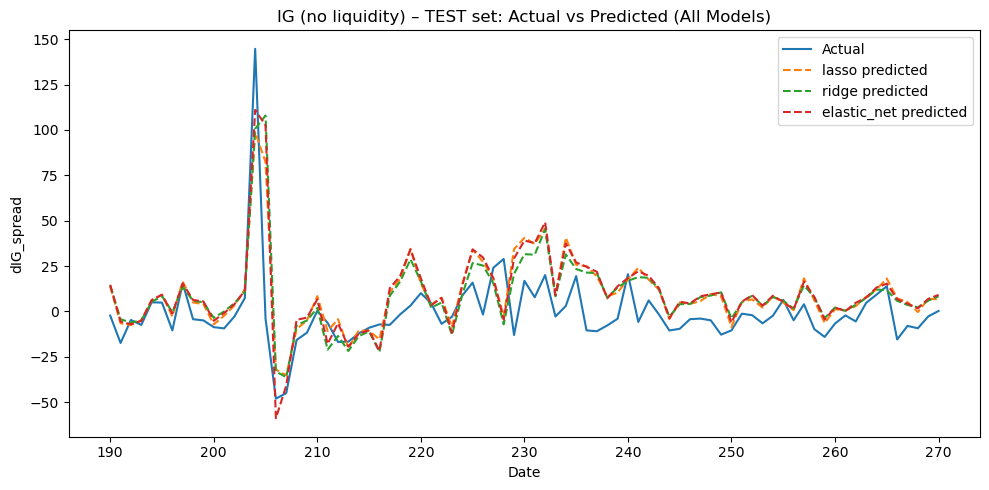

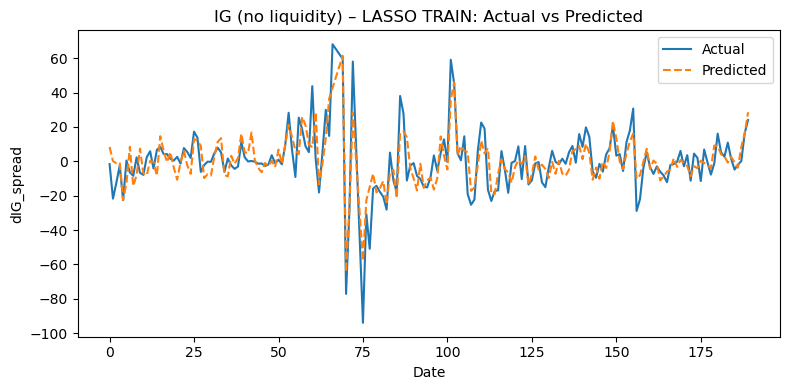

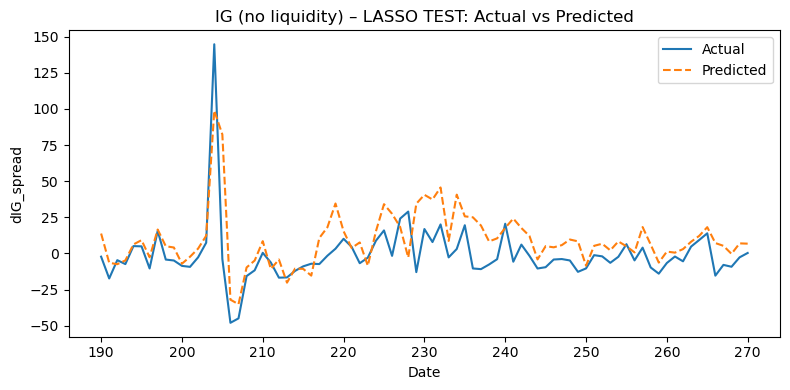

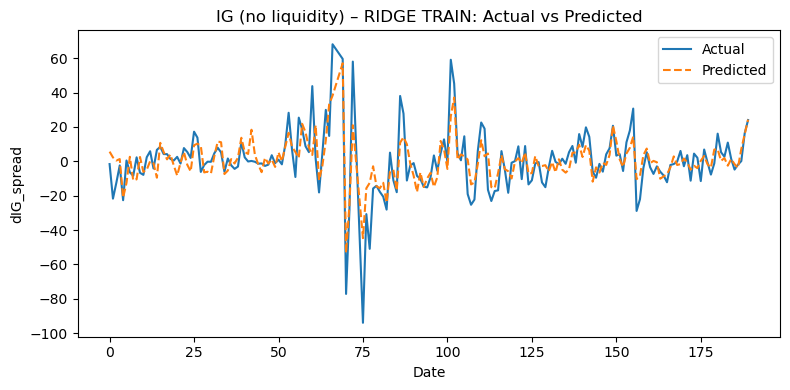

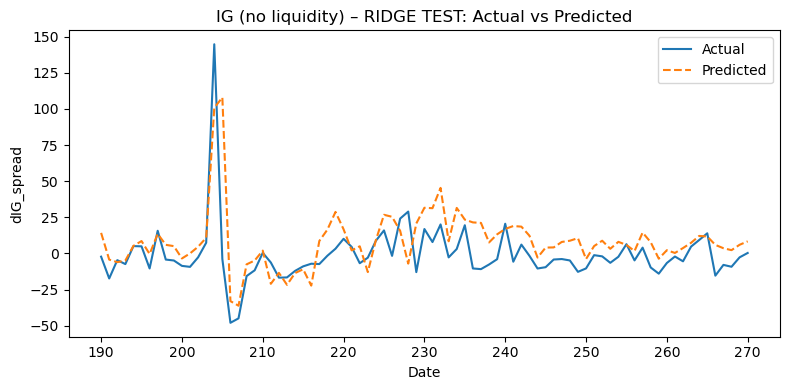

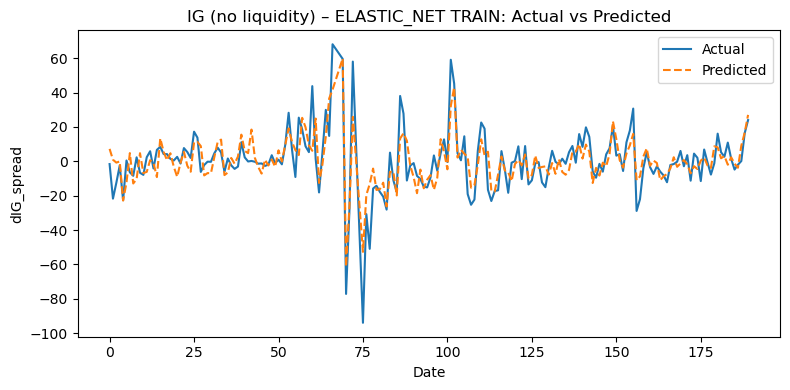

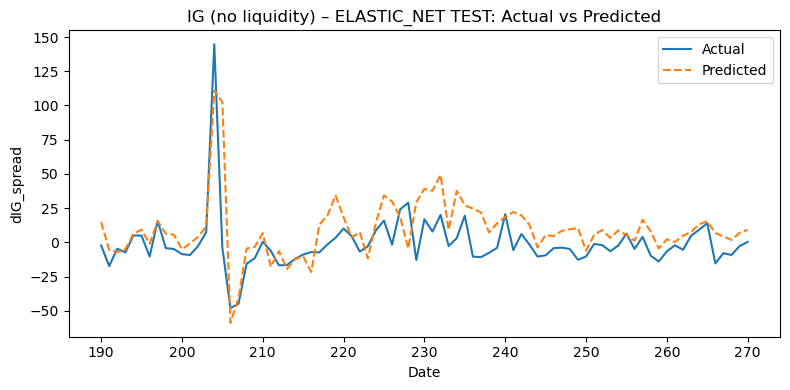

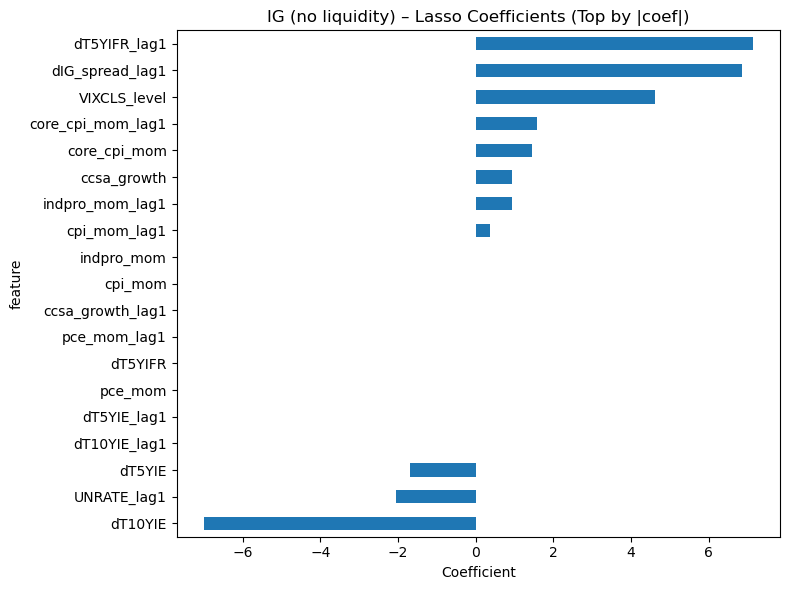

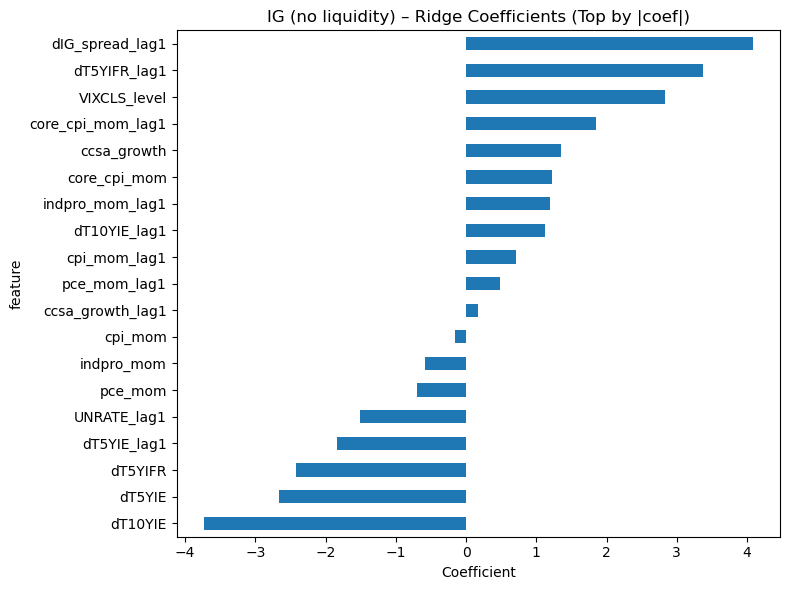

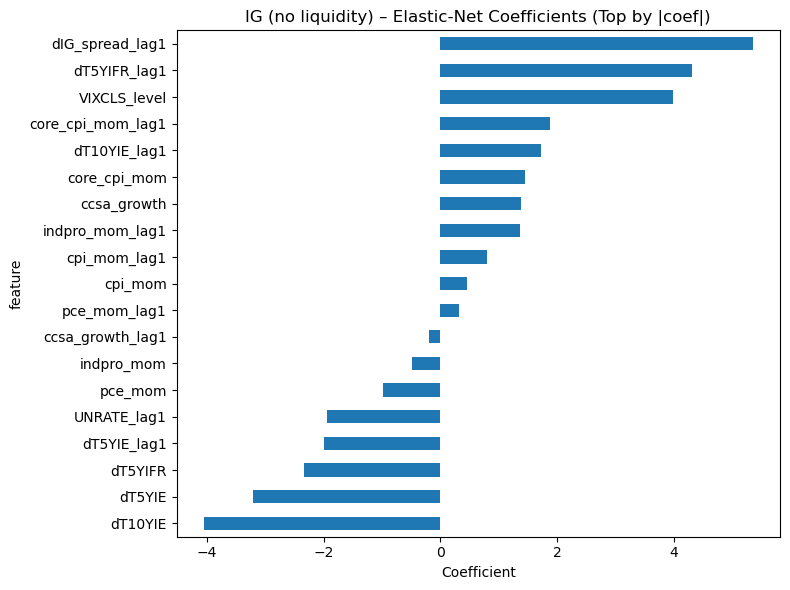

IG (no liquidity) – Lasso (TRAIN) Regularized Model Diagnostics
RMSE: 10.3937
MAE : 7.7470
R^2 : 0.6764


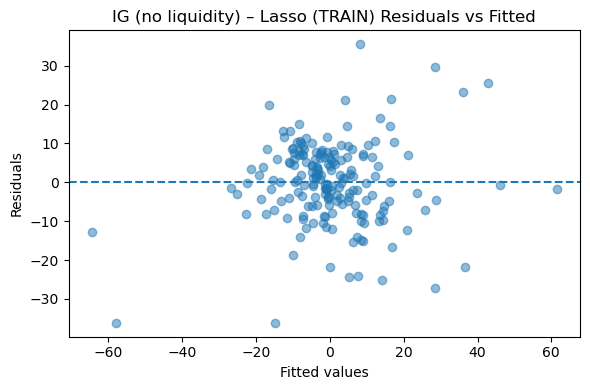

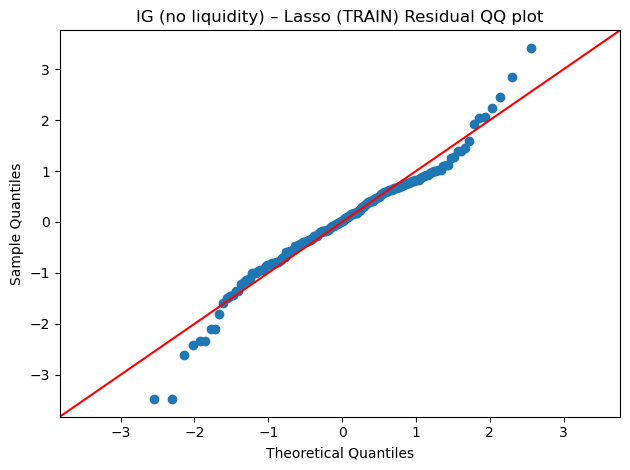

IG (no liquidity) – Lasso (TRAIN) Breusch–Pagan test:
{'LM stat': np.float64(47.47444525350737), 'LM p-value': np.float64(0.0003053887104037579), 'F-stat': np.float64(2.9942253829909733), 'F p-value': np.float64(8.309070506618834e-05)}
IG (no liquidity) – Lasso (TRAIN) Jarque–Bera test:
{'JB stat': np.float64(26.859315993951355), 'JB p-value': np.float64(1.470867791533812e-06), 'skew': np.float64(-0.2849104862683908), 'kurtosis': np.float64(4.772292936290486)}
IG (no liquidity) – Lasso (TRAIN) Durbin–Watson: 2.222
IG (no liquidity) – Ridge (TRAIN) Regularized Model Diagnostics
RMSE: 11.0300
MAE : 7.7972
R^2 : 0.6356


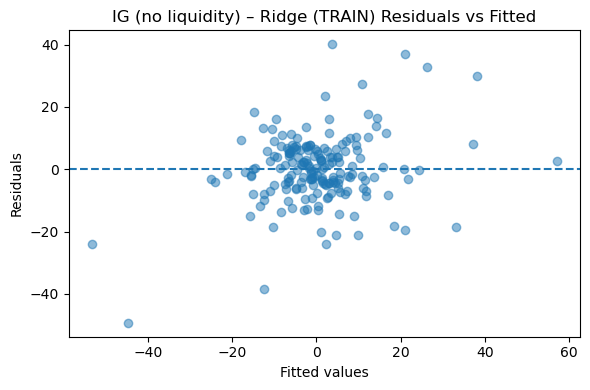

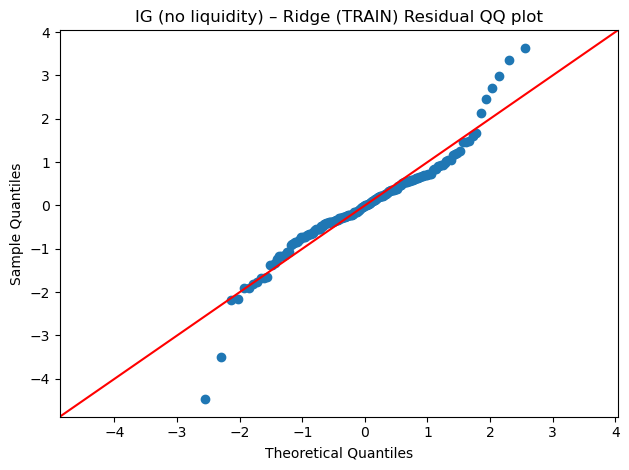

IG (no liquidity) – Ridge (TRAIN) Breusch–Pagan test:
{'LM stat': np.float64(65.78416799341134), 'LM p-value': np.float64(4.5505896533492e-07), 'F-stat': np.float64(4.78095005617098), 'F p-value': np.float64(9.038931242514187e-09)}
IG (no liquidity) – Ridge (TRAIN) Jarque–Bera test:
{'JB stat': np.float64(102.60726580042773), 'JB p-value': np.float64(5.23739500698976e-23), 'skew': np.float64(-0.11216252119566099), 'kurtosis': np.float64(6.631711094706092)}
IG (no liquidity) – Ridge (TRAIN) Durbin–Watson: 2.058
IG (no liquidity) – Elastic-Net (TRAIN) Regularized Model Diagnostics
RMSE: 10.5272
MAE : 7.7167
R^2 : 0.6680


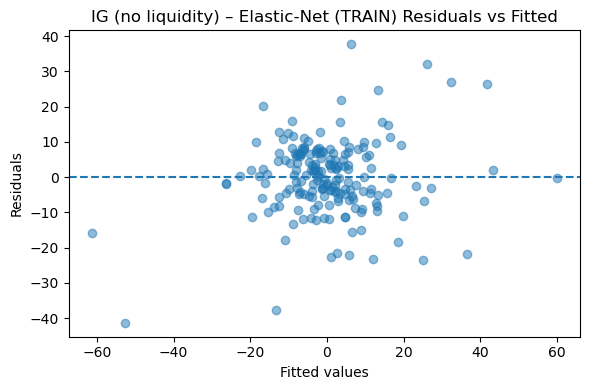

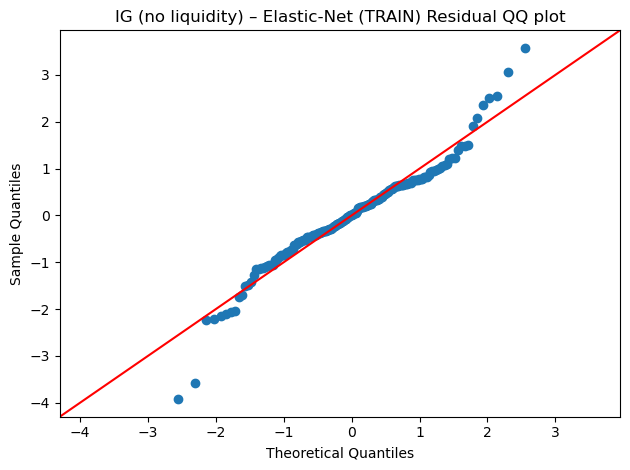

IG (no liquidity) – Elastic-Net (TRAIN) Breusch–Pagan test:
{'LM stat': np.float64(54.184041595622595), 'LM p-value': np.float64(3.09661461859672e-05), 'F-stat': np.float64(3.5913513187356614), 'F p-value': np.float64(3.906537933279845e-06)}
IG (no liquidity) – Elastic-Net (TRAIN) Jarque–Bera test:
{'JB stat': np.float64(49.20057209319175), 'JB p-value': np.float64(2.071245208334349e-11), 'skew': np.float64(-0.1892231482023992), 'kurtosis': np.float64(5.491031777394267)}
IG (no liquidity) – Elastic-Net (TRAIN) Durbin–Watson: 2.144


################################################################################
REGULARIZED PIPELINE FOR HY (no liquidity) (target = dHY_spread)
################################################################################

Shape of full design matrix (with const): (268, 20)
Train size: 187, Test size: 81

Top variables by VIF (full model):
             variable           VIF
18       dT10YIE_lag1  44885.336477
17            dT10YIE  32416.375591
16    

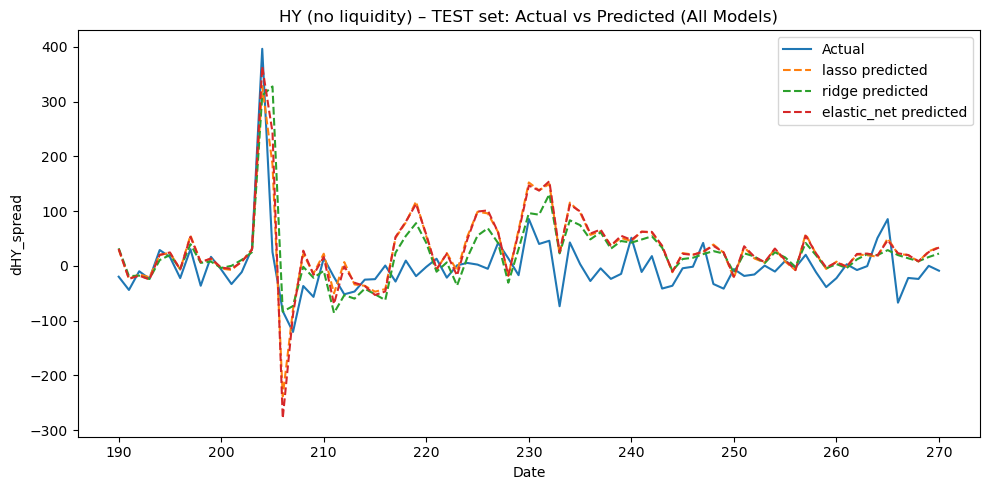

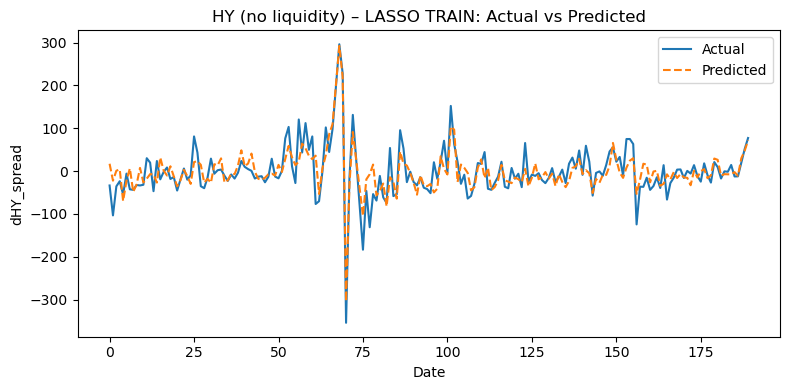

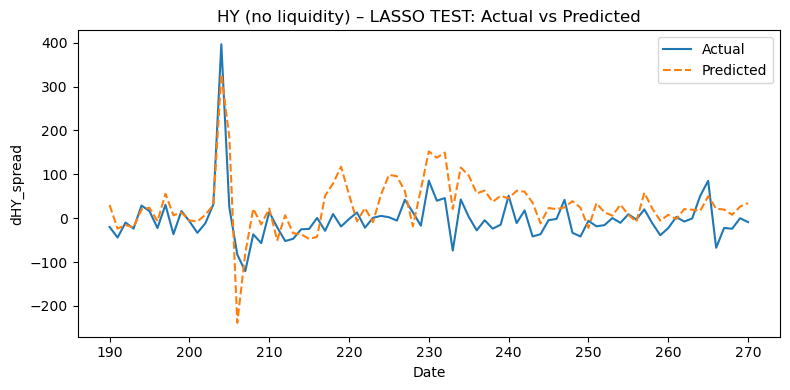

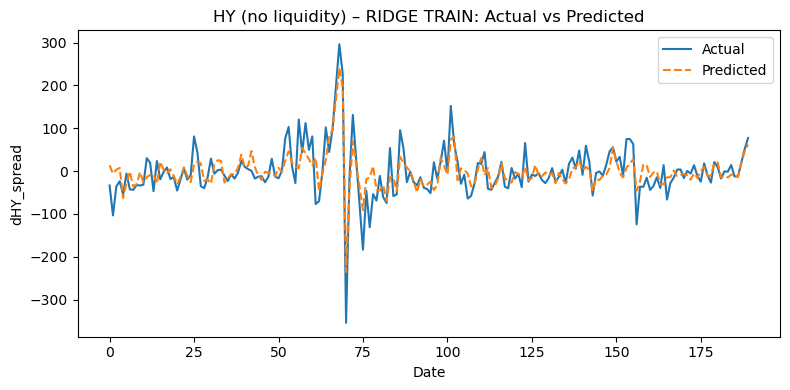

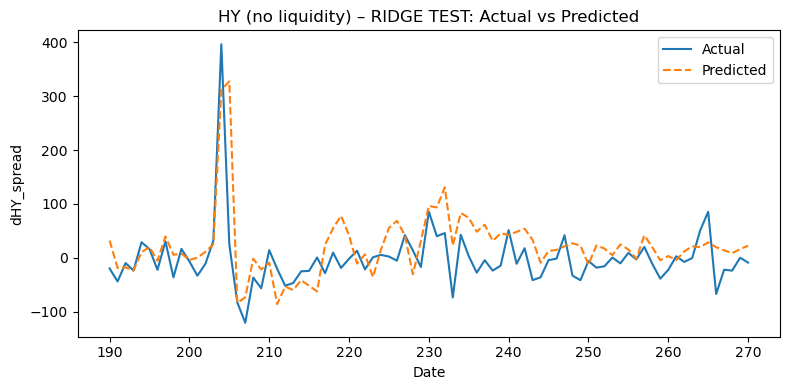

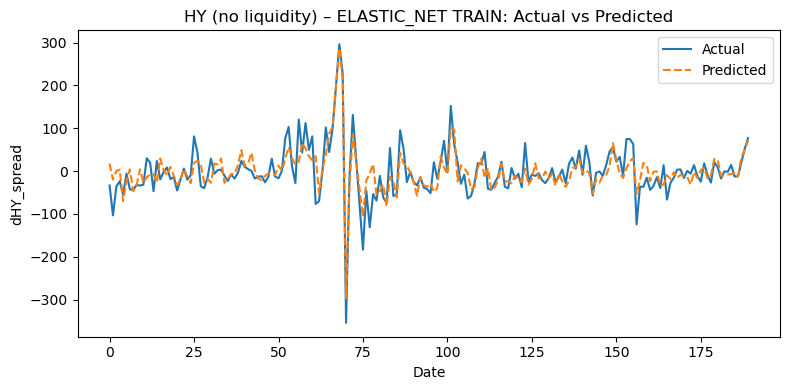

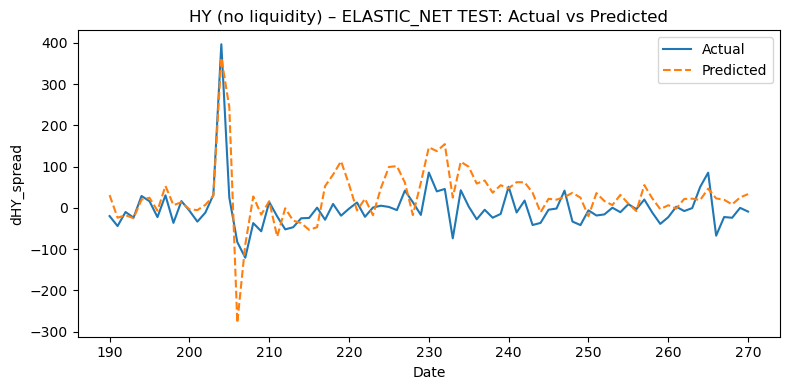

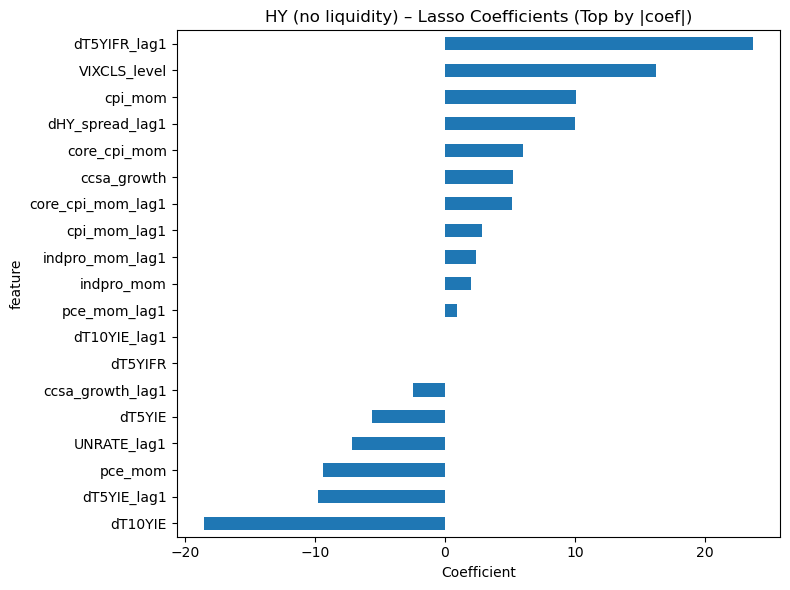

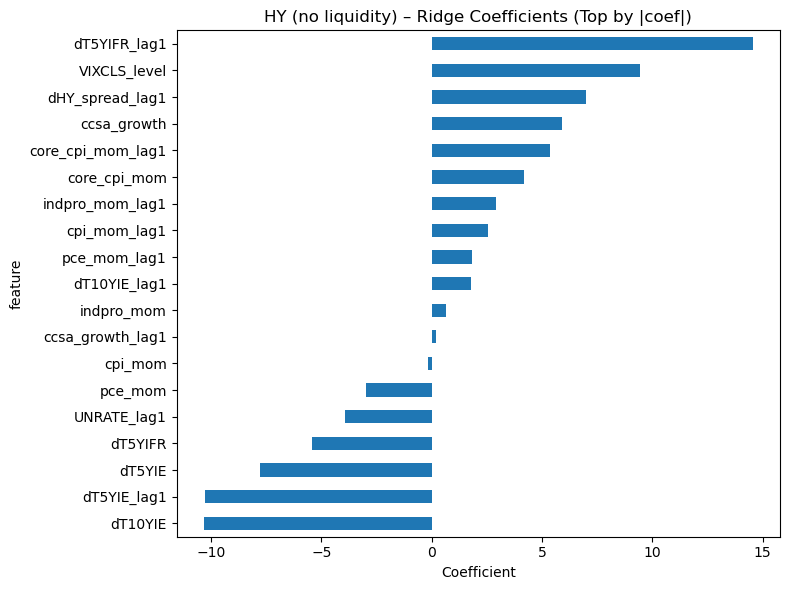

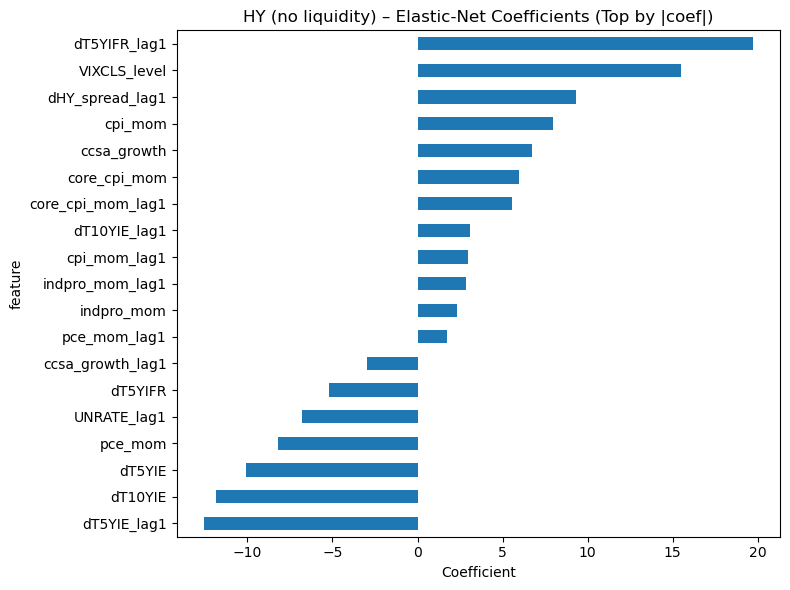

HY (no liquidity) – Lasso (TRAIN) Regularized Model Diagnostics
RMSE: 33.4182
MAE : 24.7687
R^2 : 0.6817


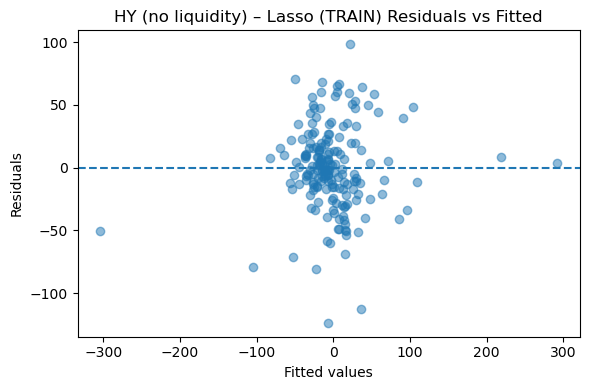

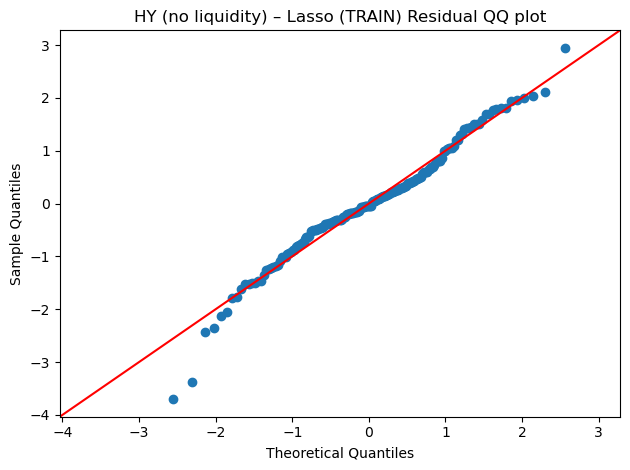

HY (no liquidity) – Lasso (TRAIN) Breusch–Pagan test:
{'LM stat': np.float64(30.726539326599266), 'LM p-value': np.float64(0.043249804202710844), 'F-stat': np.float64(1.728189211746129), 'F p-value': np.float64(0.03587692957584286)}
HY (no liquidity) – Lasso (TRAIN) Jarque–Bera test:
{'JB stat': np.float64(13.26249064138997), 'JB p-value': np.float64(0.001318520082853983), 'skew': np.float64(-0.2705757691815025), 'kurtosis': np.float64(4.187136407012892)}
HY (no liquidity) – Lasso (TRAIN) Durbin–Watson: 1.947
HY (no liquidity) – Ridge (TRAIN) Regularized Model Diagnostics
RMSE: 35.6112
MAE : 25.6976
R^2 : 0.6386


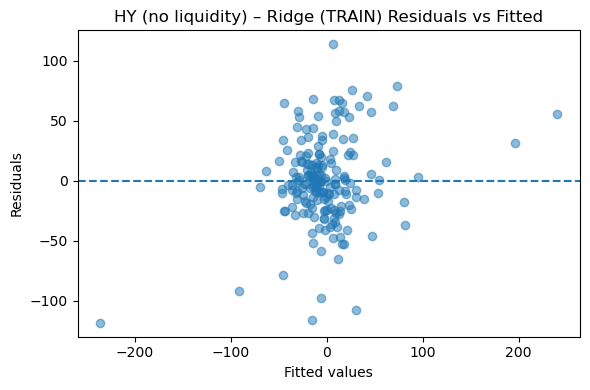

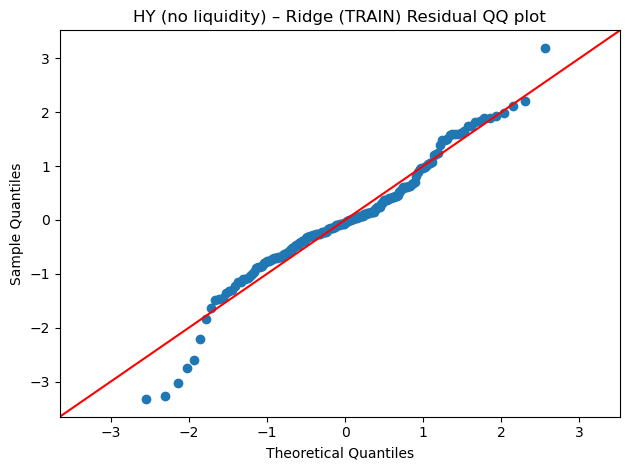

HY (no liquidity) – Ridge (TRAIN) Breusch–Pagan test:
{'LM stat': np.float64(66.04740685235039), 'LM p-value': np.float64(4.1219413473616465e-07), 'F-stat': np.float64(4.799582458975669), 'F p-value': np.float64(8.01780826447448e-09)}
HY (no liquidity) – Ridge (TRAIN) Jarque–Bera test:
{'JB stat': np.float64(17.148491539481768), 'JB p-value': np.float64(0.00018890888109970364), 'skew': np.float64(-0.20166784133300875), 'kurtosis': np.float64(4.427654106075424)}
HY (no liquidity) – Ridge (TRAIN) Durbin–Watson: 1.956
HY (no liquidity) – Elastic-Net (TRAIN) Regularized Model Diagnostics
RMSE: 33.5323
MAE : 24.8278
R^2 : 0.6796


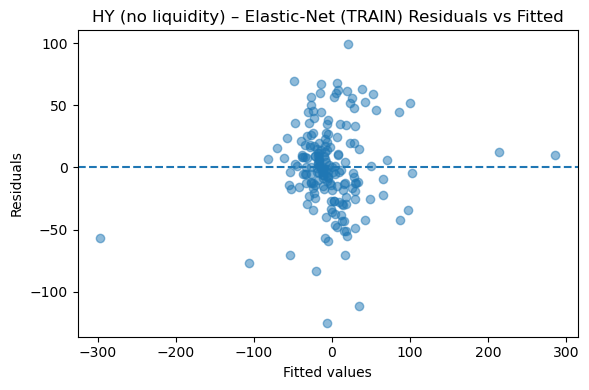

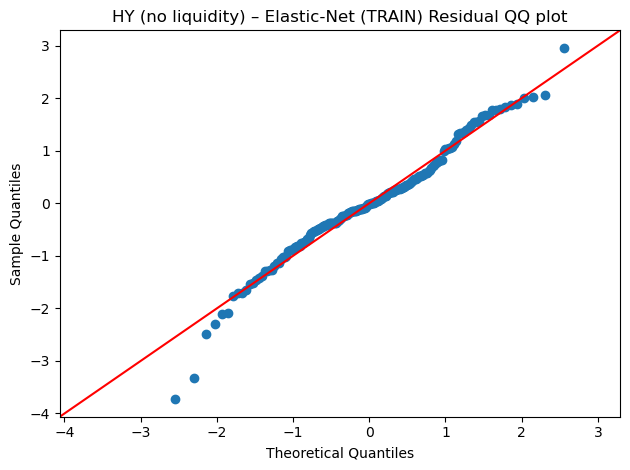

HY (no liquidity) – Elastic-Net (TRAIN) Breusch–Pagan test:
{'LM stat': np.float64(32.02784071010518), 'LM p-value': np.float64(0.031029819816639614), 'F-stat': np.float64(1.8165060380746214), 'F p-value': np.float64(0.024496990082055834)}
HY (no liquidity) – Elastic-Net (TRAIN) Jarque–Bera test:
{'JB stat': np.float64(12.860107602625819), 'JB p-value': np.float64(0.001612364084848429), 'skew': np.float64(-0.2661816553510685), 'kurtosis': np.float64(4.169223844609488)}
HY (no liquidity) – Elastic-Net (TRAIN) Durbin–Watson: 1.956


In [158]:
ig_wo = load_data(IG_WO_LQD_FILE)
hy_wo = load_data(HY_WO_LQD_FILE)
ig_trim = trim_extreme_points(ig_wo, target="dIG_spread")
hy_trim = trim_extreme_points(hy_wo, target="dHY_spread")

# IG without liquidity
model_ig_wo, sel_ig_wo, X_ig_wo, y_ig_wo = run_ols_pipeline(
    ig_trim, IG_TARGET, label="IG (no liquidity)"
)

# HY without liquidity
model_hy_wo, sel_hy_wo, X_hy_wo, y_hy_wo = run_ols_pipeline(
    hy_trim, HY_TARGET, label="HY (no liquidity)"
)


Dropping 2 extreme obs out of 108
Dropping 2 extreme obs out of 108


################################################################################
REGULARIZED PIPELINE FOR IG (with liquidity) (target = dIG_spread)
################################################################################

Shape of full design matrix (with const): (106, 30)
Train size: 74, Test size: 32

Top variables by VIF (full model):
                 variable           VIF
27      dmkt_px_std_daily  2.079363e+10
2        mkt_px_std_daily  4.392965e+08
26  mkt_px_std_daily_lag1  1.788186e+08
22          ln_mkt_par_lb  1.989229e+05
21           dT10YIE_lag1  5.570588e+04
20                dT10YIE  5.362417e+04
19            dT5YIE_lag1  4.318155e+04
18                 dT5YIE  3.858689e+04
17           dT5YIFR_lag1  3.080467e+04
16                dT5YIFR  2.813641e+04
0              mkt_par_lb  3.664331e+02
1            mkt_n_trades  1.402802e+02
24        ln_mkt_n_trades  1.315564e+02
25   ln_mkt_n_trades_l

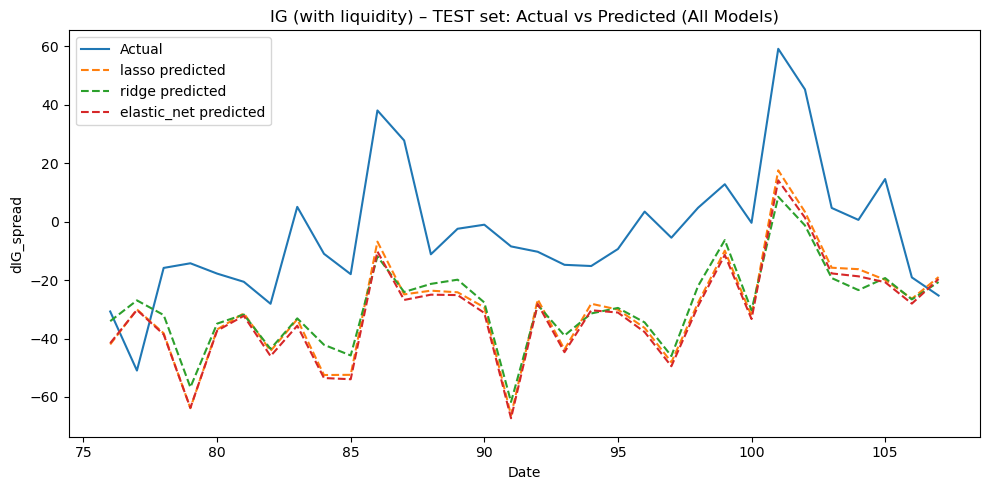

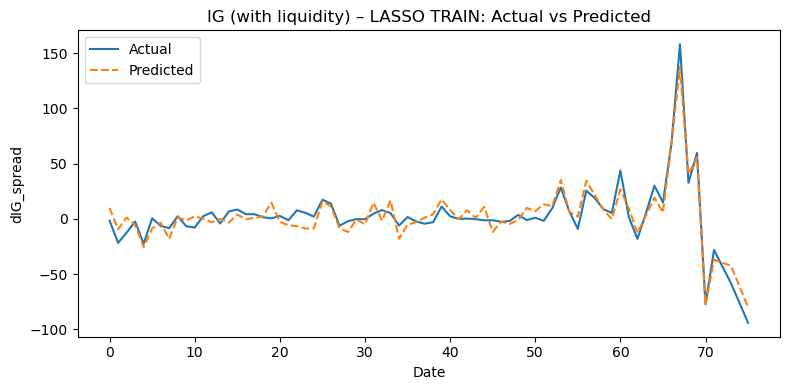

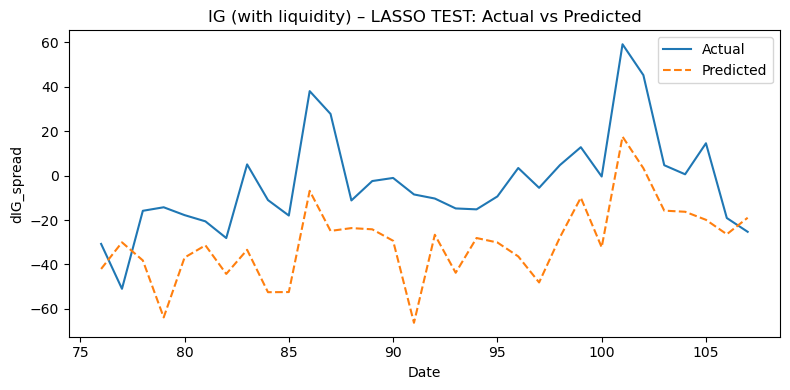

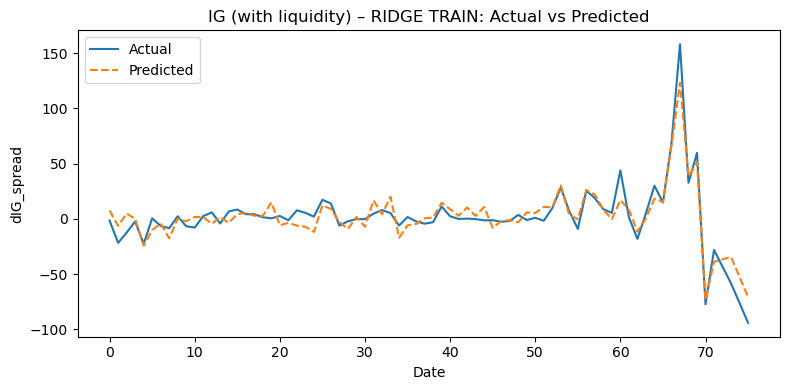

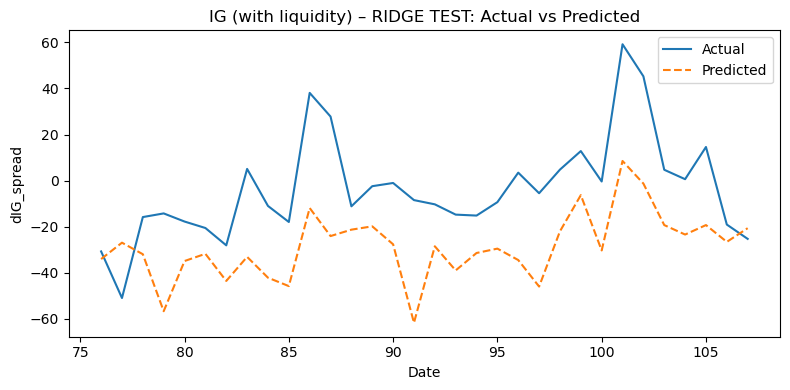

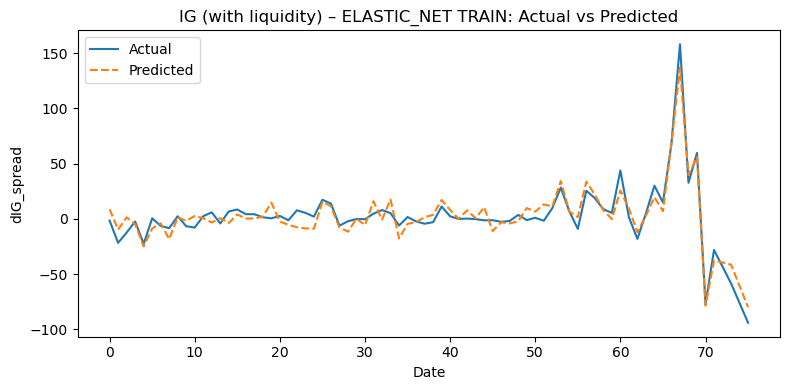

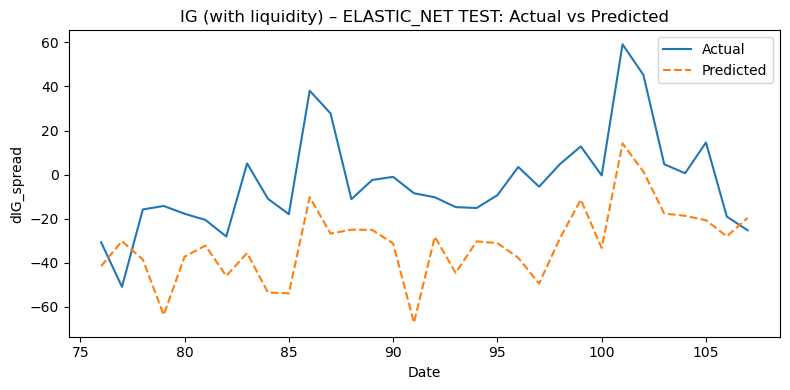

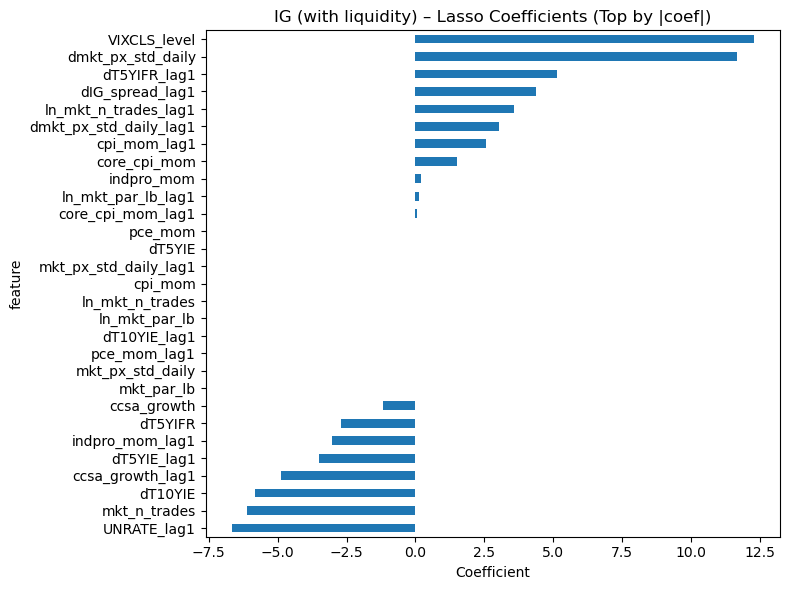

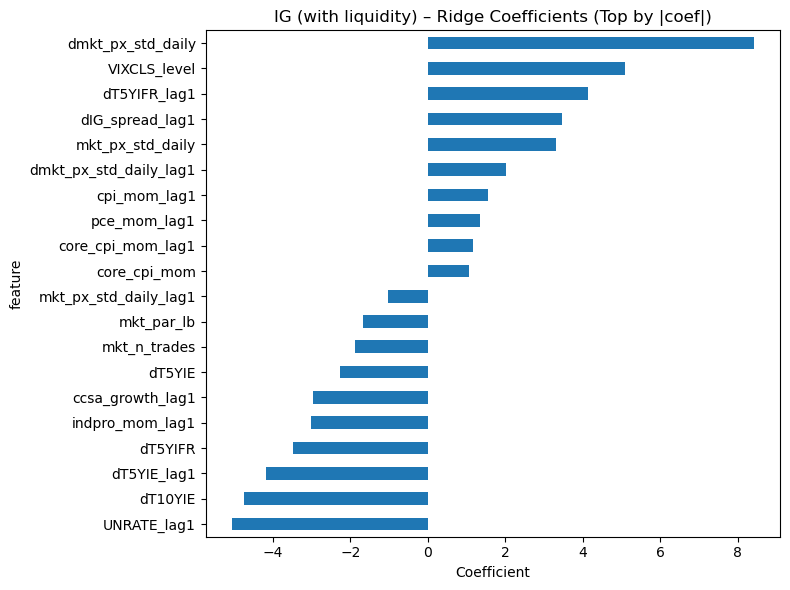

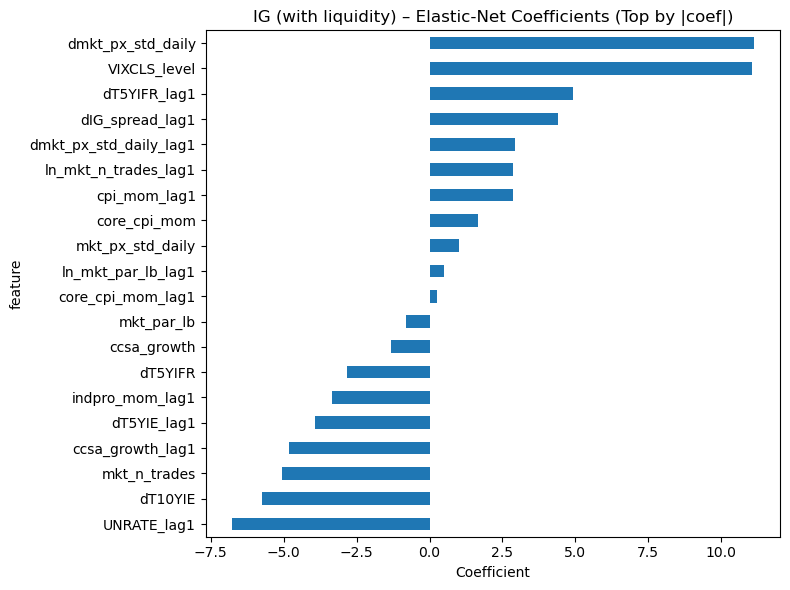

IG (with liquidity) – Lasso (TRAIN) Regularized Model Diagnostics
RMSE: 8.4380
MAE : 6.9374
R^2 : 0.9131


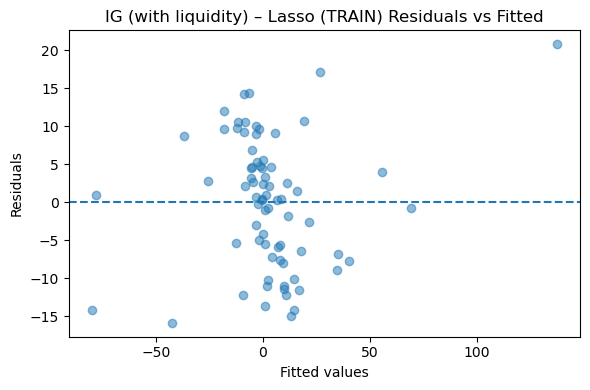

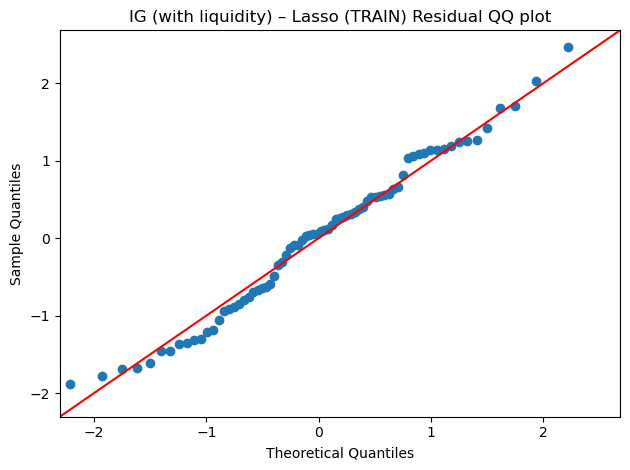

IG (with liquidity) – Lasso (TRAIN) Breusch–Pagan test:
{'LM stat': np.float64(34.39751470500773), 'LM p-value': np.float64(0.22500659167409381), 'F-stat': np.float64(2.1507437647589343), 'F p-value': np.float64(0.013050227929714397)}
IG (with liquidity) – Lasso (TRAIN) Jarque–Bera test:
{'JB stat': np.float64(1.4422333993331065), 'JB p-value': np.float64(0.4862090032595555), 'skew': np.float64(0.04811907589369433), 'kurtosis': np.float64(2.3228814055889244)}
IG (with liquidity) – Lasso (TRAIN) Durbin–Watson: 1.677
IG (with liquidity) – Ridge (TRAIN) Regularized Model Diagnostics
RMSE: 9.7990
MAE : 7.3655
R^2 : 0.8828


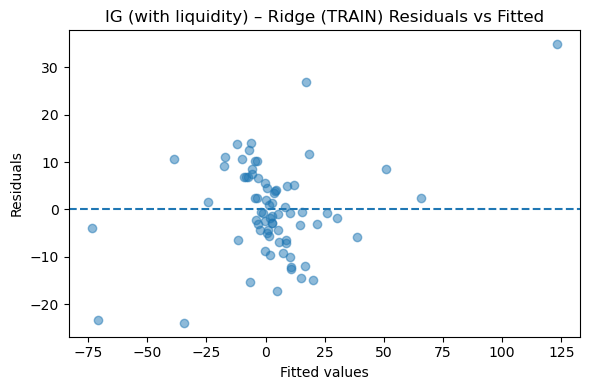

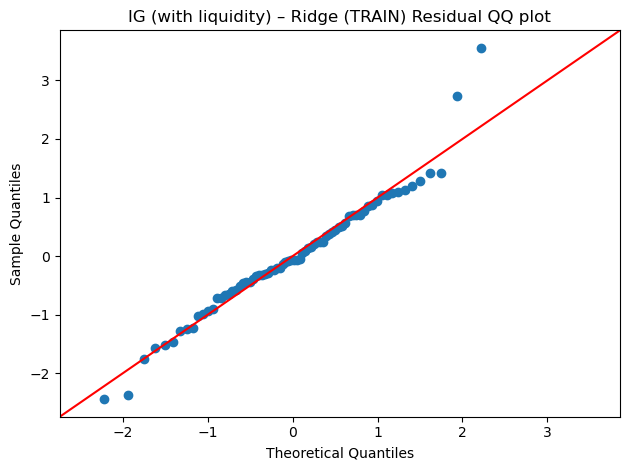

IG (with liquidity) – Ridge (TRAIN) Breusch–Pagan test:
{'LM stat': np.float64(49.77815288423242), 'LM p-value': np.float64(0.009541571069435288), 'F-stat': np.float64(5.088802167116796), 'F p-value': np.float64(9.1970923447215e-07)}
IG (with liquidity) – Ridge (TRAIN) Jarque–Bera test:
{'JB stat': np.float64(10.449250796981454), 'JB p-value': np.float64(0.005382375828422354), 'skew': np.float64(0.4119190688956472), 'kurtosis': np.float64(4.64627972323873)}
IG (with liquidity) – Ridge (TRAIN) Durbin–Watson: 1.733
IG (with liquidity) – Elastic-Net (TRAIN) Regularized Model Diagnostics
RMSE: 8.4686
MAE : 6.8924
R^2 : 0.9124


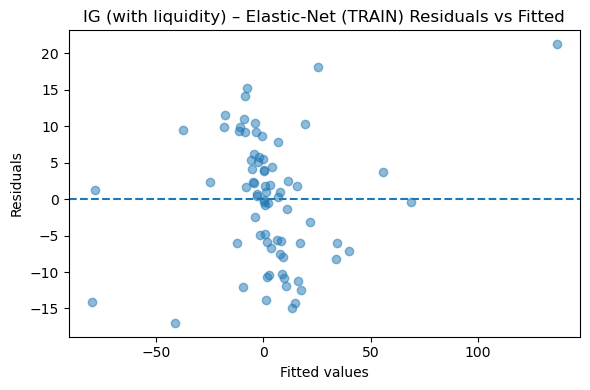

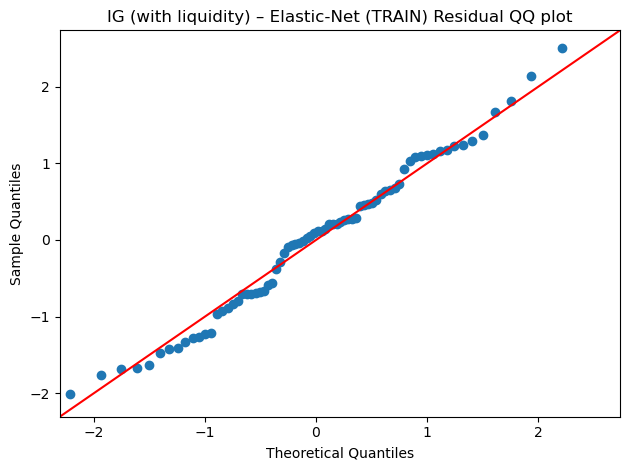

IG (with liquidity) – Elastic-Net (TRAIN) Breusch–Pagan test:
{'LM stat': np.float64(36.157403935089235), 'LM p-value': np.float64(0.16902369624600136), 'F-stat': np.float64(2.3659217014146234), 'F p-value': np.float64(0.006123904484019342)}
IG (with liquidity) – Elastic-Net (TRAIN) Jarque–Bera test:
{'JB stat': np.float64(1.0020987419671363), 'JB p-value': np.float64(0.6058945178704573), 'skew': np.float64(0.06974235835923392), 'kurtosis': np.float64(2.4472351212344297)}
IG (with liquidity) – Elastic-Net (TRAIN) Durbin–Watson: 1.709


################################################################################
REGULARIZED PIPELINE FOR HY (with liquidity) (target = dHY_spread)
################################################################################

Shape of full design matrix (with const): (106, 30)
Train size: 74, Test size: 32

Top variables by VIF (full model):
                 variable           VIF
2        mkt_px_std_daily  2.698334e+10
27      dmkt_px_std_daily  2.7

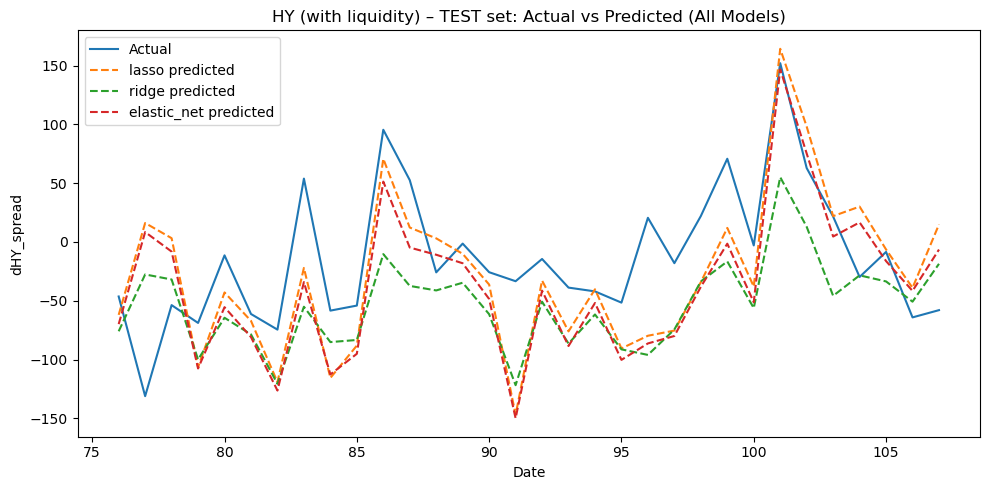

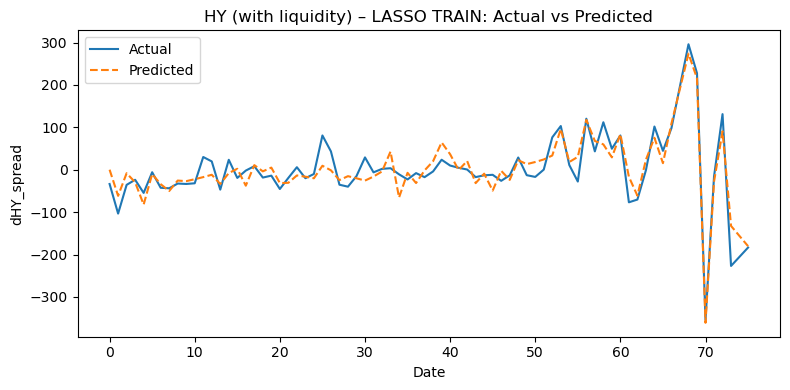

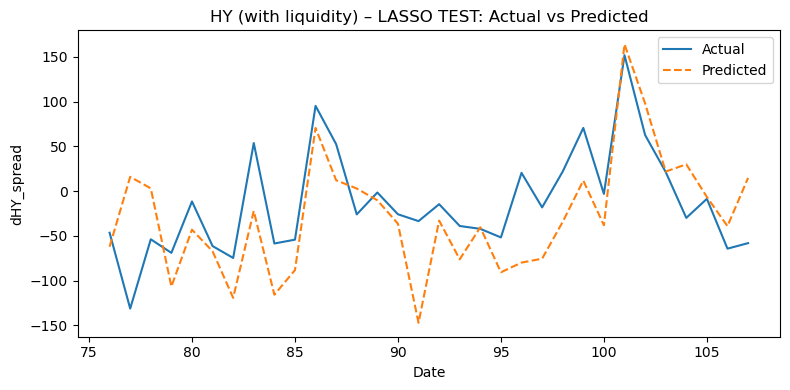

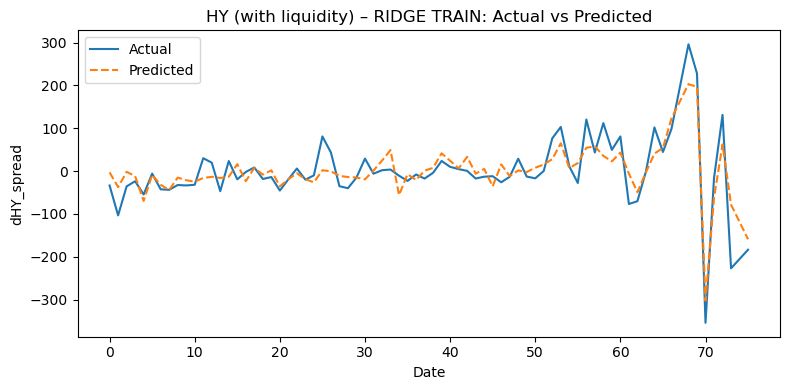

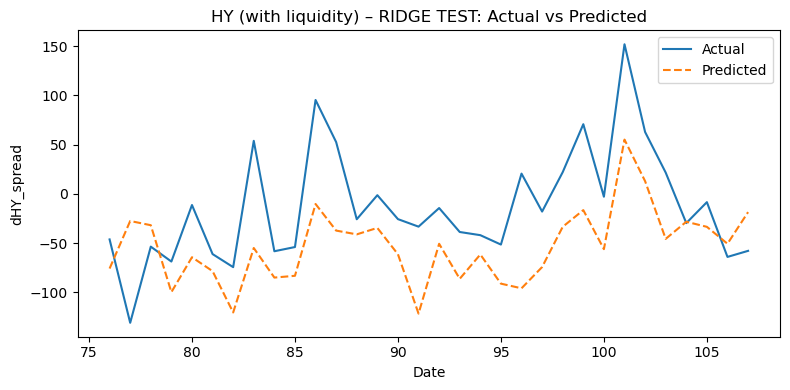

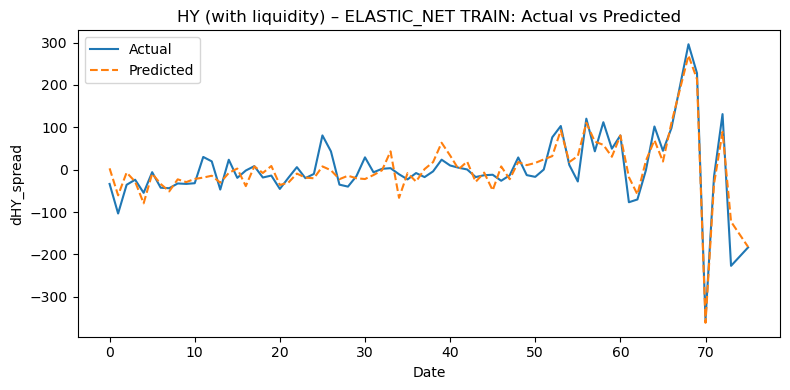

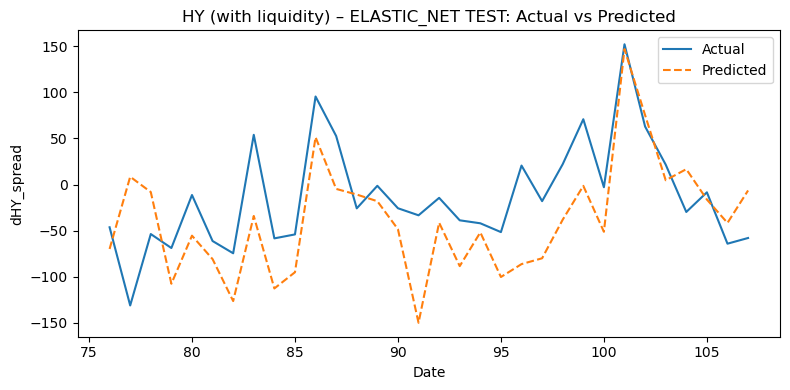

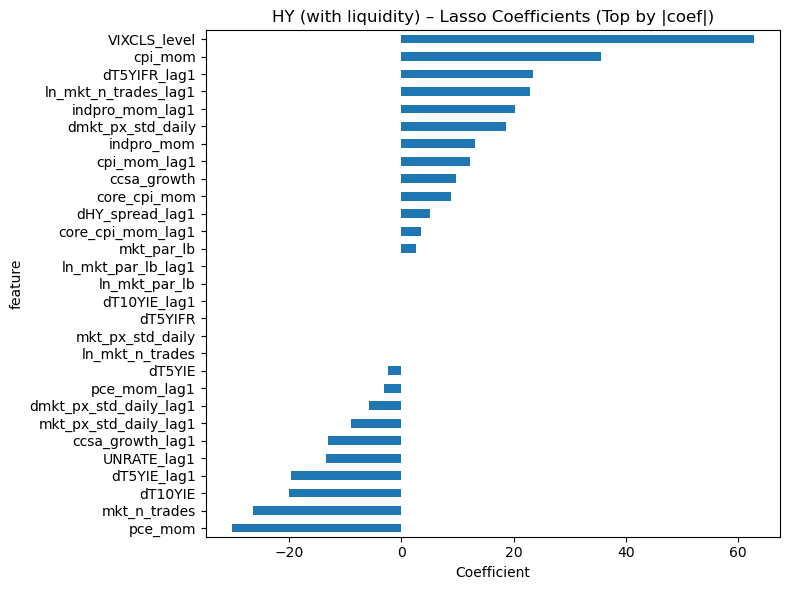

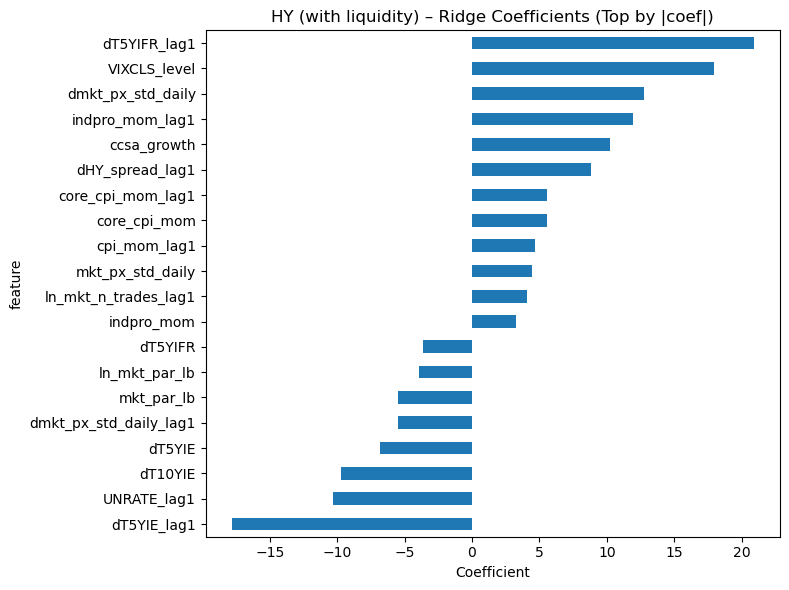

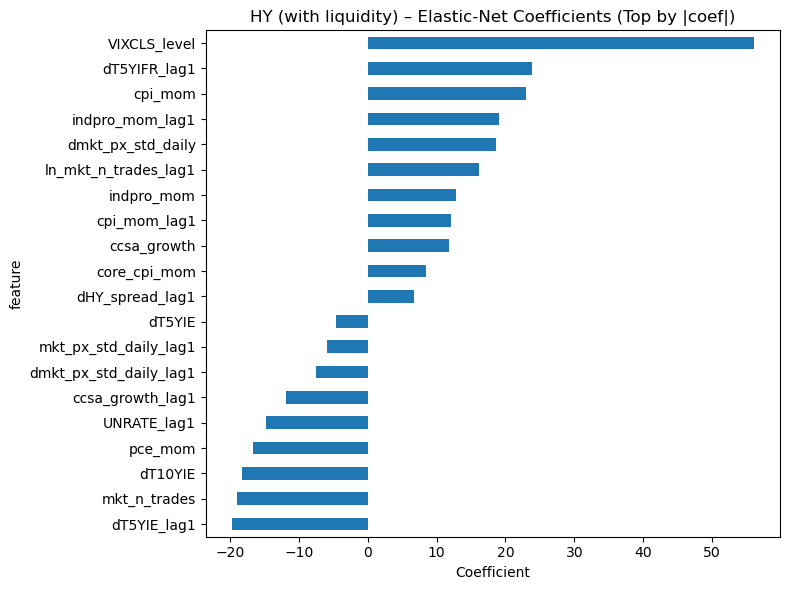

HY (with liquidity) – Lasso (TRAIN) Regularized Model Diagnostics
RMSE: 29.3039
MAE : 22.9616
R^2 : 0.8739


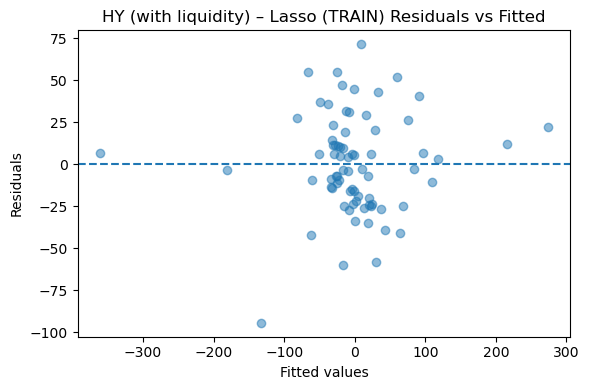

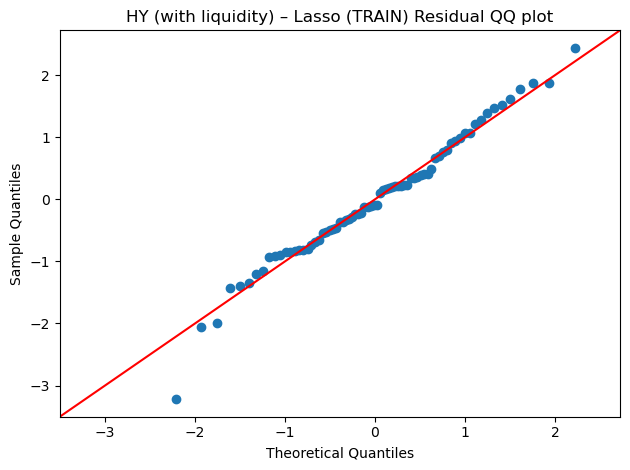

HY (with liquidity) – Lasso (TRAIN) Breusch–Pagan test:
{'LM stat': np.float64(42.95362741728499), 'LM p-value': np.float64(0.04597968268824527), 'F-stat': np.float64(3.425886964576713), 'F p-value': np.float64(0.00015861424137421395)}
HY (with liquidity) – Lasso (TRAIN) Jarque–Bera test:
{'JB stat': np.float64(1.2396726346626532), 'JB p-value': np.float64(0.5380324969825192), 'skew': np.float64(-0.14872515357307306), 'kurtosis': np.float64(3.5599815214799353)}
HY (with liquidity) – Lasso (TRAIN) Durbin–Watson: 1.932
HY (with liquidity) – Ridge (TRAIN) Regularized Model Diagnostics
RMSE: 38.4174
MAE : 28.7913
R^2 : 0.7832


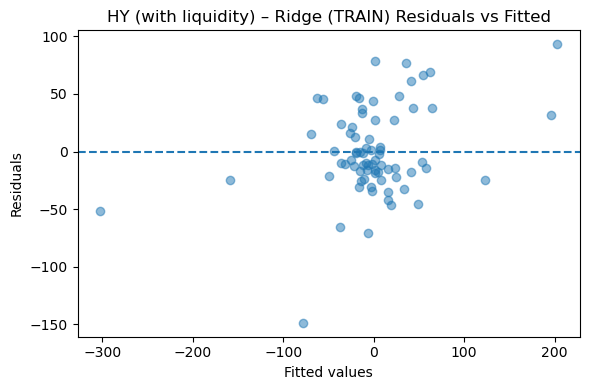

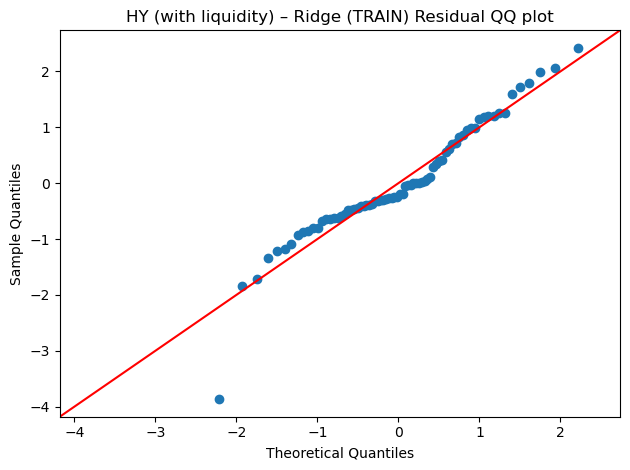

HY (with liquidity) – Ridge (TRAIN) Breusch–Pagan test:
{'LM stat': np.float64(49.917885984920666), 'LM p-value': np.float64(0.009217380532661863), 'F-stat': np.float64(5.132696979593443), 'F p-value': np.float64(8.11272532933214e-07)}
HY (with liquidity) – Ridge (TRAIN) Jarque–Bera test:
{'JB stat': np.float64(12.873035322537474), 'JB p-value': np.float64(0.0016019756002315232), 'skew': np.float64(-0.2763192799756837), 'kurtosis': np.float64(4.9671372867799555)}
HY (with liquidity) – Ridge (TRAIN) Durbin–Watson: 2.079
HY (with liquidity) – Elastic-Net (TRAIN) Regularized Model Diagnostics
RMSE: 30.0406
MAE : 23.2756
R^2 : 0.8675


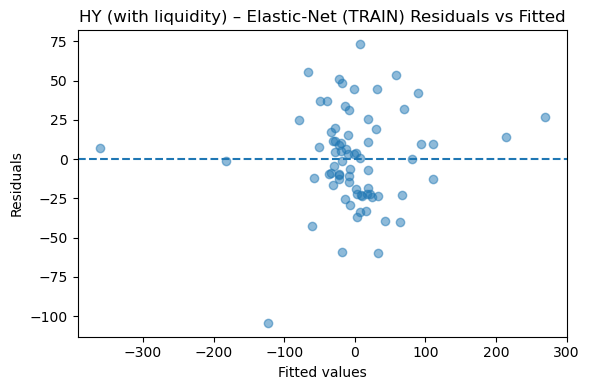

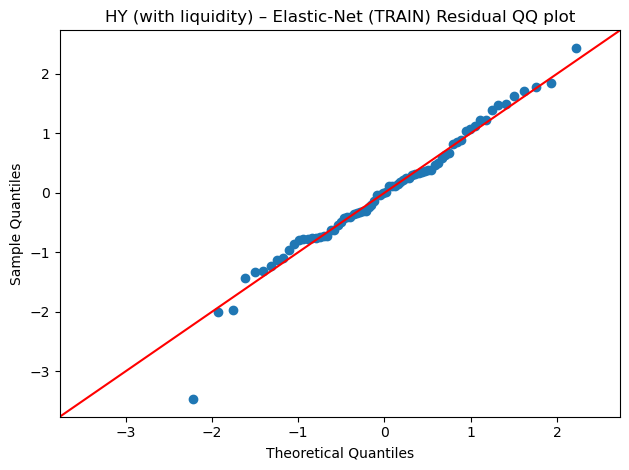

HY (with liquidity) – Elastic-Net (TRAIN) Breusch–Pagan test:
{'LM stat': np.float64(43.6768767453954), 'LM p-value': np.float64(0.03937248904089673), 'F-stat': np.float64(3.566659849600759), 'F p-value': np.float64(9.95047152081915e-05)}
HY (with liquidity) – Elastic-Net (TRAIN) Jarque–Bera test:
{'JB stat': np.float64(3.717569612364696), 'JB p-value': np.float64(0.15586191777314706), 'skew': np.float64(-0.273108691583161), 'kurtosis': np.float64(3.952546493870906)}
HY (with liquidity) – Elastic-Net (TRAIN) Durbin–Watson: 1.980


In [159]:
ig_w = load_data(IG_W_LQD_FILE)
hy_w = load_data(HY_W_LQD_FILE)
ig_trim = trim_extreme_points(ig_w, target="dIG_spread")
hy_trim = trim_extreme_points(hy_w, target="dHY_spread")

# IG without liquidity
model_ig_w, sel_ig_w, X_ig_w, y_ig_w = run_ols_pipeline(
    ig_trim, IG_TARGET, label="IG (with liquidity)"
)

# HY without liquidity
model_hy_w, sel_hy_w, X_hy_w, y_hy_w = run_ols_pipeline(
    hy_trim, HY_TARGET, label="HY (with liquidity)"
)